In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# IMPORTANT: This script requires you to have the following libraries installed:
# pip install scikit-learn numpy pandas tqdm

# Step 1: Load and Prepare Data
def prepare_data(df, target_column='market_forward_excess_returns'):
    """Prepare the competition data for LGMM modeling."""
    print("Preparing data...")
    
    # Fill missing values. This is crucial as LGMM does not handle NaN by default.
    df.ffill(inplace=True)
    
    # Define features and target.
    # We will use date_id as our primary LGMM feature to capture time-based regimes.
    # The other features can be added as exogenous variables if needed later, but we'll
    # start with the core LGMM approach for simplicity.
    X = df[['date_id']].values
    y = df[target_column].values
    
    # Store the full dataframe for later use in predictions
    return X, y, df

# Step 2: Train the LGMM Model with Rolling Windows
def train_lgmm_rolling(X, y, train_window=252, n_components=3, degree=2):
    """
    Trains LGMM models using a rolling window to predict daily excess returns.
    This avoids lookahead bias by only using historical data for each prediction.
    """
    predictions = np.full_like(y, np.nan)
    
    # We loop from the end of the training window to the last data point
    for i in tqdm(range(train_window, len(X)), desc="Training LGMM models"):
        # Get the training data for the current window
        X_train = X[i-train_window:i]
        y_train = y[i-train_window:i]
        
        # Train a Gaussian Mixture Model to find hidden market regimes
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X_train)
        
        # Get the probability of each training data point belonging to each regime
        latent_features = gmm.predict_proba(X_train)
        
        # Combine the original features (date_id) with the latent features
        X_latent = np.hstack([X_train, latent_features])
        
        # Train a polynomial regression on the enhanced features to predict the target
        poly_reg = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
        )
        poly_reg.fit(X_latent, y_train)
        
        # Make a prediction for the current day using only the current data point
        current_latent = gmm.predict_proba(X[i].reshape(1, -1))
        current_X_latent = np.hstack([X[i].reshape(1, -1), current_latent])
        predictions[i] = poly_reg.predict(current_X_latent)[0]

    return predictions

# Step 3: Implement the Betting Strategy
def get_allocations(predictions, min_alloc=0, max_alloc=2):
    """
    Translates LGMM predictions into daily market allocations (0 to 2)
    based on the predicted market excess returns.
    """
    # Assuming a reasonable range for predictions to avoid extreme allocations
    min_pred, max_pred = np.nanpercentile(predictions, 5), np.nanpercentile(predictions, 95)
    
    # Clamp predictions to the assumed range
    clamped_predictions = np.clip(predictions, min_pred, max_pred)

    # Scale the clamped predictions to the allocation range [0, 2]
    # We want a positive prediction to map to >1 (leveraged long)
    # and a negative prediction to map to <1 (cash or short)
    
    # Normalize clamped predictions to a [0, 1] range
    normalized_predictions = (clamped_predictions - min_pred) / (max_pred - min_pred)
    
    # Scale to the final allocation range [0, 2]
    allocations = min_alloc + (max_alloc - min_alloc) * normalized_predictions
    
    return allocations

# Main execution block
if __name__ == "__main__":
    # Load your dataset. In your local environment, this should point to your file.
    try:
        df_train = pd.read_csv('train.csv')
    except FileNotFoundError:
        print("Error: train.csv not found. Please ensure the file is in the correct directory.")
        exit()

    # Prepare data for the LGMM model
    X, y, df = prepare_data(df_train)
    
    # Train the rolling LGMM model and get predictions
    lgmm_predictions = train_lgmm_rolling(X, y)

    # Get the daily allocations from the predictions
    daily_allocations = get_allocations(lgmm_predictions)

    # Display a summary of the final allocations
    print("\nLGMM Model predictions (Excess Returns):")
    print(pd.Series(lgmm_predictions).describe())

    print("\nFinal Allocations (0-2):")
    print(pd.Series(daily_allocations).describe())
    
    # Note: For the competition submission, you would need to implement
    # the volatility constraint logic by adjusting the allocations.
    # This script provides the core model predictions for you to use.

ModuleNotFoundError: No module named 'tqdm'

In [3]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# Step 1: Load and Prepare Data
def prepare_data(df, target_column='market_forward_excess_returns'):
    """Prepare the competition data for LGMM modeling."""
    print("Preparing data...")
    
    # Fill missing values. This is crucial as LGMM does not handle NaN by default.
    df.ffill(inplace=True)
    
    # We will use date_id as our primary LGMM feature to capture time-based regimes.
    X = df[['date_id']].values
    y = df[target_column].values
    
    return X, y, df

# Step 2: Train the LGMM Model with Rolling Windows
def train_lgmm_rolling(X, y, train_window=252, n_components=3, degree=2):
    """
    Trains LGMM models using a rolling window to predict daily excess returns.
    This avoids lookahead bias by only using historical data for each prediction.
    """
    predictions = np.full_like(y, np.nan)
    
    for i in tqdm(range(train_window, len(X)), desc="Training LGMM models"):
        X_train = X[i-train_window:i]
        y_train = y[i-train_window:i]
        
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X_train)
        
        latent_features = gmm.predict_proba(X_train)
        X_latent = np.hstack([X_train, latent_features])
        
        poly_reg = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
        )
        poly_reg.fit(X_latent, y_train)
        
        current_latent = gmm.predict_proba(X[i].reshape(1, -1))
        current_X_latent = np.hstack([X[i].reshape(1, -1), current_latent])
        predictions[i] = poly_reg.predict(current_X_latent)[0]

    return predictions

# Step 3: Implement the Betting Strategy with Volatility Control
def get_volatility_controlled_allocations(df, predictions, train_window=252, max_vol_ratio=1.2):
    """
    Translates LGMM predictions into daily allocations (0-2) and dynamically
    adjusts them to stay within the volatility constraint.
    """
    allocations = np.full_like(predictions, np.nan)
    
    # Calculate initial allocations (before volatility control)
    min_pred, max_pred = np.nanpercentile(predictions, 5), np.nanpercentile(predictions, 95)
    clamped_predictions = np.clip(predictions, min_pred, max_pred)
    normalized_predictions = (clamped_predictions - min_pred) / (max_pred - min_pred)
    initial_allocations = 2 * normalized_predictions
    
    # Now, dynamically adjust allocations to manage volatility
    for i in tqdm(range(train_window, len(df)), desc="Applying Volatility Control"):
        # Calculate market volatility over the trailing window
        market_returns = df['forward_returns'].iloc[i-train_window:i]
        market_vol = market_returns.std()
        
        # Get the strategy's returns for the trailing window
        strategy_returns = initial_allocations[i-train_window:i] * market_returns
        strategy_vol = strategy_returns.std()
        
        # Calculate the ratio of strategy volatility to market volatility
        vol_ratio = strategy_vol / market_vol if market_vol > 0 else 0
        
        # Apply a scaling factor to control volatility
        if vol_ratio > max_vol_ratio:
            scaling_factor = max_vol_ratio / vol_ratio
            allocations[i] = initial_allocations[i] * scaling_factor
        else:
            allocations[i] = initial_allocations[i]
            
    # Clamp final allocations to ensure they are within the [0, 2] range
    allocations = np.clip(allocations, 0, 2)
    
    return allocations

# Main execution block
if __name__ == "__main__":
    try:
        df_train = pd.read_csv('train.csv')
    except FileNotFoundError:
        print("Error: train.csv not found. Please ensure the file is in the correct directory.")
        exit()

    X, y, df = prepare_data(df_train)
    
    # Train the rolling LGMM model and get predictions
    lgmm_predictions = train_lgmm_rolling(X, y)

    # Get the daily allocations with volatility control
    volatility_controlled_allocations = get_volatility_controlled_allocations(df, lgmm_predictions)

    # Display a summary of the final allocations
    print("\nFinal Volatility-Controlled Allocations (0-2):")
    allocations_series = pd.Series(volatility_controlled_allocations)
    print(allocations_series.describe())
    
    # You can now use these 'volatility_controlled_allocations' for your final submission.

Preparing data...


Applying Volatility Control: 100%|██████████| 8738/8738 [00:01<00:00, 4679.94it/s]


Final Volatility-Controlled Allocations (0-2):
count    8738.000000
mean        1.061313
std         0.519633
min         0.000000
25%         0.727309
50%         1.089563
75%         1.420577
max         2.000000
dtype: float64


In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Step 1: Load and Prepare Data
def prepare_data(df, target_column='market_forward_excess_returns'):
    """Prepares the data for LGMM modeling."""
    print("Preparing data...")
    df.ffill(inplace=True)
    X = df[['date_id']].values
    return X, df

# Step 2: Train the LGMM Model with Rolling Windows
def train_lgmm_rolling(X, y, train_window=252, n_components=3, degree=2):
    """
    Trains LGMM models using a rolling window to predict daily excess returns.
    """
    predictions = np.full_like(y, np.nan)
    
    # Removed tqdm for compatibility
    for i in range(train_window, len(X)):
        X_train = X[i-train_window:i]
        y_train = y[i-train_window:i]
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X_train)
        latent_features = gmm.predict_proba(X_train)
        X_latent = np.hstack([X_train, latent_features])
        poly_reg = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
        )
        poly_reg.fit(X_latent, y_train)
        current_latent = gmm.predict_proba(X[i].reshape(1, -1))
        current_X_latent = np.hstack([X[i].reshape(1, -1), current_latent])
        predictions[i] = poly_reg.predict(current_X_latent)[0]
    return predictions

# Step 3: Implement the Betting Strategy with Volatility Control
def get_volatility_controlled_allocations(df, predictions, train_window=252, max_vol_ratio=1.2):
    """
    Translates predictions into daily allocations (0-2) and adjusts them
    to stay within the volatility constraint.
    """
    allocations = np.full_like(predictions, np.nan)
    min_pred, max_pred = np.nanpercentile(predictions, 5), np.nanpercentile(predictions, 95)
    clamped_predictions = np.clip(predictions, min_pred, max_pred)
    normalized_predictions = (clamped_predictions - min_pred) / (max_pred - min_pred)
    initial_allocations = 2 * normalized_predictions
    
    # Removed tqdm for compatibility
    for i in range(train_window, len(df)):
        market_returns = df['forward_returns'].iloc[i-train_window:i]
        market_vol = market_returns.std()
        strategy_returns = initial_allocations[i-train_window:i] * market_returns
        strategy_vol = strategy_returns.std()
        vol_ratio = strategy_vol / market_vol if market_vol > 0 else 0
        if vol_ratio > max_vol_ratio:
            scaling_factor = max_vol_ratio / vol_ratio
            allocations[i] = initial_allocations[i] * scaling_factor
        else:
            allocations[i] = initial_allocations[i]
    allocations = np.clip(allocations, 0, 2)
    return allocations

# Main execution block
if __name__ == "__main__":
    try:
        df_train = pd.read_csv('train.csv')
        df_test = pd.read_csv('test.csv')
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found. Please ensure both files are in the correct directory.")
        exit()

    # The test.csv is a mock set, a copy of the last 180 rows of the train set.
    # To run the LGMM rolling window correctly, we need to concatenate them.
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    test_start_index = len(df_train)
    
    # Prepare data for the LGMM model
    X_combined, df_combined = prepare_data(df_combined)
    
    # We need a target variable for LGMM, which is missing for the test set.
    # We'll use the LGMM predictions as a proxy for the returns to demonstrate volatility control.
    y_combined = df_combined['market_forward_excess_returns'].values
    
    # Train the rolling LGMM model and get predictions
    lgmm_predictions = train_lgmm_rolling(X_combined, y_combined)
    
    # Fill the returns for the test set with the LGMM predictions.
    df_combined.loc[test_start_index:, 'forward_returns'] = lgmm_predictions[test_start_index:]
    
    # Get the daily allocations with volatility control
    volatility_controlled_allocations = get_volatility_controlled_allocations(df_combined, lgmm_predictions)

    # Isolate the results for the test dataset
    test_allocations = volatility_controlled_allocations[test_start_index:]

    # Display a summary of the final allocations on the test set
    print("\nFinal Volatility-Controlled Allocations for the Test Dataset (0-2):")
    allocations_series = pd.Series(test_allocations)
    print(allocations_series.describe())

Preparing data...

Final Volatility-Controlled Allocations for the Test Dataset (0-2):
count    10.000000
mean      1.172755
std       0.068826
min       1.059335
25%       1.118424
50%       1.185673
75%       1.215507
max       1.265858
dtype: float64


In [2]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Step 1: Load and Prepare Data
def prepare_data(df, target_column='market_forward_excess_returns'):
    """Prepares the data for LGMM modeling."""
    print("Preparing data...")
    
    # Fill missing values. This is crucial as LGMM does not handle NaN by default.
    df.ffill(inplace=True)
    
    # Define features and target.
    # We will use date_id as our primary LGMM feature to capture time-based regimes.
    X = df[['date_id']].values
    
    return X, df

# Step 2: Train the LGMM Model with Rolling Windows
def train_lgmm_rolling(X, y, train_window=252, n_components=3, degree=2):
    """
    Trains LGMM models using a rolling window to predict daily excess returns.
    """
    predictions = np.full_like(y, np.nan)
    
    for i in range(train_window, len(X)):
        X_train = X[i-train_window:i]
        y_train = y[i-train_window:i]
        
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X_train)
        
        latent_features = gmm.predict_proba(X_train)
        X_latent = np.hstack([X_train, latent_features])
        
        poly_reg = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
        )
        poly_reg.fit(X_latent, y_train)
        
        current_latent = gmm.predict_proba(X[i].reshape(1, -1))
        current_X_latent = np.hstack([X[i].reshape(1, -1), current_latent])
        predictions[i] = poly_reg.predict(current_X_latent)[0]

    return predictions

# Step 3: Implement the Betting Strategy with Volatility Control
def get_volatility_controlled_allocations(df, predictions, train_window=252, max_vol_ratio=1.2):
    """
    Translates predictions into daily allocations (0-2) and adjusts them
    to stay within the volatility constraint.
    """
    allocations = np.full_like(predictions, np.nan)
    min_pred, max_pred = np.nanpercentile(predictions, 5), np.nanpercentile(predictions, 95)
    clamped_predictions = np.clip(predictions, min_pred, max_pred)
    normalized_predictions = (clamped_predictions - min_pred) / (max_pred - min_pred)
    initial_allocations = 2 * normalized_predictions
    
    for i in range(train_window, len(df)):
        market_returns = df['forward_returns'].iloc[i-train_window:i]
        market_vol = market_returns.std()
        strategy_returns = initial_allocations[i-train_window:i] * market_returns
        strategy_vol = strategy_returns.std()
        vol_ratio = strategy_vol / market_vol if market_vol > 0 else 0
        if vol_ratio > max_vol_ratio:
            scaling_factor = max_vol_ratio / vol_ratio
            allocations[i] = initial_allocations[i] * scaling_factor
        else:
            allocations[i] = initial_allocations[i]
    allocations = np.clip(allocations, 0, 2)
    return allocations

# Main execution block
if __name__ == "__main__":
    try:
        df_train = pd.read_csv('train.csv')
        df_test = pd.read_csv('test.csv')
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found. Please ensure both files are in the correct directory.")
        exit()

    # The test.csv is a mock set, a copy of the last 180 rows of the train set.
    # To run the LGMM rolling window correctly, we need to concatenate them.
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    test_start_index = len(df_train)
    
    # Prepare data for the LGMM model
    X_combined, df_combined = prepare_data(df_combined)
    
    # We use the target variable from the training data for the LGMM model training.
    y_combined = df_combined['market_forward_excess_returns'].values
    
    # Train the rolling LGMM model and get predictions
    lgmm_predictions = train_lgmm_rolling(X_combined, y_combined)
    
    # Fill the returns for the test set with the LGMM predictions.
    df_combined.loc[test_start_index:, 'forward_returns'] = lgmm_predictions[test_start_index:]
    
    # Get the daily allocations with volatility control
    volatility_controlled_allocations = get_volatility_controlled_allocations(df_combined, lgmm_predictions)

    # Isolate the allocations for the test dataset
    test_allocations = volatility_controlled_allocations[test_start_index:]

    # Create the final submission DataFrame
    final_submission = pd.DataFrame({
        'date_id': df_test['date_id'],
        'allocation': test_allocations
    })
    
    print("\nLGMM Model Allocations for the Test Dataset:")
    print(final_submission.head())

    # You can now save this DataFrame to a CSV file for submission
    # final_submission.to_csv('submission.csv', index=False)

Preparing data...

LGMM Model Allocations for the Test Dataset:
   date_id  allocation
0     8980    1.265858
1     8981    1.245989
2     8982    1.221437
3     8983    1.197717
4     8984    1.191588


In [3]:
# =========================================================
# Hull Tactical - LGMM-style Regimes + Vol-Targeted Alloc
# =========================================================

import os, sys, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Tree model: LightGBM preferred; fall back to HistGradientBoosting
USE_LIGHTGBM = True
try:
    import lightgbm as lgb
except Exception:
    USE_LIGHTGBM = False
    from sklearn.ensemble import HistGradientBoostingRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------
# 1) Load data
# ---------------------------
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

# Combined to keep contiguous time index; NEVER train on future rows
comb = pd.concat([train, test], ignore_index=True)

# ---------------------------
# 2) Feature list & helpers
# ---------------------------
drop_cols = {
    'date_id','is_scored','forward_returns','risk_free_rate','market_forward_excess_returns',
    'lagged_forward_returns','lagged_risk_free_rate','lagged_market_forward_excess_returns'
}
base_features = [c for c in comb.columns if c not in drop_cols]

def make_lags(df, cols, lags=(1,2,3,4,5)):
    out = df.copy()
    for L in lags:
        out[[f'{c}_lag{L}' for c in cols]] = df[cols].shift(L)
    return out

def rolling_zscore(s, win=63):
    mu = s.rolling(win).mean()
    sd = s.rolling(win).std()
    return (s - mu) / sd

def add_rolling_zscores(df, cols, win=63, clip=5.0):
    out = df.copy()
    for c in cols:
        z = rolling_zscore(out[c], win=win)
        out[f'{c}_z{win}'] = z.clip(-clip, clip)
    return out

# Create lagged & z-scored features across the entire timeline (uses only past info)
feat_df = comb.copy()
feat_df = make_lags(feat_df, base_features, lags=(1,2,3,4,5))
feat_df = add_rolling_zscores(feat_df, base_features, win=63, clip=5.0)

# Final candidate features (exclude original contemporaneous raw cols to be safe)
cand_features = [c for c in feat_df.columns if (
    c.endswith(tuple([f'_lag{L}' for L in (1,2,3,4,5)])) or c.endswith('_z63')
)]

# Target and market returns (train part only has these)
y_all = comb['market_forward_excess_returns'].values  # what we predict
mkt_ret = comb['forward_returns'].values              # needed for proxy Sharpe during train

# ---------------------------
# 3) Column pruning (based on early window only to avoid leakage)
# ---------------------------
FIRST_WIN = 252
early_slice = feat_df.iloc[:FIRST_WIN]
na_ratio = early_slice[cand_features].isna().mean()
keep_cols = [c for c in cand_features if na_ratio[c] <= 0.40]   # drop >40% missing in start window
X_all = feat_df[keep_cols].copy()

# Fill remaining missing with rolling median then ffill (past-only safe)
X_all = X_all.fillna(X_all.rolling(63, min_periods=1).median())
X_all = X_all.ffill().bfill()  # bfill only affects the very beginning pre-lag area

# Standardize features within each training window later (avoid global fit)

# ---------------------------
# 4) Walk-forward daily loop
# ---------------------------
N = len(comb)
preds = np.full(N, np.nan)
vol_window = 252
start_idx = max(FIRST_WIN, int(np.argmax(~np.any(pd.isna(X_all.iloc[:].values), axis=1))))  # ensure no NaNs

def fit_predict_one_day(X_tr, y_tr, X_te, n_pca=12, n_gmm=3):
    # Standardize -> PCA -> GMM -> concat regimes -> models -> blend
    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(X_tr)
    Xs_te = scaler.transform(X_te)

    pca = PCA(n_components=min(n_pca, Xs_tr.shape[1]), random_state=RANDOM_STATE).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr)
    Z_te = pca.transform(Xs_te)

    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full',
                          random_state=RANDOM_STATE).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr)
    R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr])
    Xr_te = np.hstack([Xs_te, R_te])

    # Linear model
    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    ridge.fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    # Tree model
    if USE_LIGHTGBM:
        lgbm = lgb.LGBMRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=-1,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
            reg_lambda=1.0
        )
        lgbm.fit(Xr_tr, y_tr)
        p2 = lgbm.predict(Xr_te)
    else:
        hgb = HistGradientBoostingRegressor(
            max_depth=None, max_iter=300, learning_rate=0.05,
            random_state=RANDOM_STATE
        )
        hgb.fit(Xr_tr, y_tr)
        p2 = hgb.predict(Xr_te)

    return 0.5 * p1 + 0.5 * p2

# Daily expanding window (fits on rows [0, t-1], predicts row t)
for t in range(start_idx, N):
    X_tr = X_all.iloc[:t].values
    y_tr = y_all[:t]
    # keep rows in train with finite target (training part)
    mask = np.isfinite(y_tr)
    X_tr = X_tr[mask]
    y_tr = y_tr[mask]

    X_te = X_all.iloc[t:t+1].values

    preds[t] = fit_predict_one_day(X_tr, y_tr, X_te)

    if (t % 500) == 0:
        print(f"Trained up to index {t}/{N}")

gc.collect()

# ---------------------------
# 5) Proxy validation on training region (optional print)
# ---------------------------
def proxy_sharpe(alloc, mkt):
    strat = alloc * mkt
    mu = np.nanmean(strat)
    sd = np.nanstd(strat)
    return mu / sd if sd > 0 else 0.0

# Map predictions to raw allocations for the TRAIN part to get a first-pass k
def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

z_pred = zscore_series(preds, win=vol_window)
raw_alloc = np.clip(1.0 + 0.5 * z_pred.values, 0, 2)  # k = 0.5 default; can tune

train_len = len(train)
print("\nProxy metrics on training region:")
mkt_train = mkt_ret[:train_len]
alloc_train = raw_alloc[:train_len]
print("  Market vol:", np.nanstd(mkt_train))
print("  Strat vol :", np.nanstd(alloc_train * mkt_train))
print("  Vol ratio :", np.nanstd(alloc_train * mkt_train) / np.nanstd(mkt_train))
print("  Proxy Sharpe:", proxy_sharpe(alloc_train, mkt_train))

# ---------------------------
# 6) Volatility targeting (0..2) using past-only window
# ---------------------------
def vol_target_allocations(preds, market_returns, window=252, max_ratio=1.2, k=0.5):
    z = zscore_series(preds, win=window).values
    raw = np.clip(1.0 + k * z, 0, 2)
    alloc = raw.copy()

    for i in range(window, len(alloc)):
        past_strat = raw[i-window:i] * market_returns[i-window:i]
        mvol = np.nanstd(market_returns[i-window:i])
        svol = np.nanstd(past_strat)
        if mvol > 0 and svol > mvol * max_ratio:
            alloc[i] = raw[i] * (mvol * max_ratio / svol)
    return np.clip(alloc, 0, 2)

allocations = vol_target_allocations(preds, mkt_ret, window=vol_window, max_ratio=1.2, k=0.5)

# ---------------------------
# 7) Build submission for the public test tail
# ---------------------------
test_start = len(train)
sub = pd.DataFrame({
    'date_id': comb.loc[test_start:, 'date_id'].astype(int).values,
    'allocation': allocations[test_start:]
})
# Ensure finite and clipped
sub['allocation'] = sub['allocation'].fillna(1.0).clip(0, 2)

print("\nSubmission preview:")
print(sub.head())

# Save
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")

# ---------------------------
# 8) (Optional) sanity plots inside Kaggle notebook if desired
# ---------------------------
# import matplotlib.pyplot as plt
# plt.plot(allocations[:len(train)] * mkt_ret[:len(train)].cumsum()); plt.title("Cum Strat (train)"); plt.show()


Trained up to index 500/9000
Trained up to index 1000/9000
Trained up to index 1500/9000
Trained up to index 2000/9000
Trained up to index 2500/9000
Trained up to index 3000/9000
Trained up to index 3500/9000
Trained up to index 4000/9000
Trained up to index 4500/9000
Trained up to index 5000/9000
Trained up to index 5500/9000
Trained up to index 6000/9000
Trained up to index 6500/9000
Trained up to index 7000/9000
Trained up to index 7500/9000
Trained up to index 8000/9000
Trained up to index 8500/9000

Proxy metrics on training region:
  Market vol: 0.010549951263508736
  Strat vol : 0.01183126734367737
  Vol ratio : 1.121452322211249
  Proxy Sharpe: 0.052239547883417975

Submission preview:
   date_id  allocation
0     8980    0.071876
1     8981    1.029094
2     8982    1.946104
3     8983    2.000000
4     8984    0.000000

Saved submission.csv


In [4]:
# ============================================================
# Hull Tactical — LGMM-style Regimes + Vol-Targeted Allocation
# With: leak-safe preprocessing, smoothing, k-tuning, turnover
# ============================================================

import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

# Try LightGBM (falls back if unavailable)
USE_LIGHTGBM = True
try:
    import lightgbm as lgb
except Exception:
    USE_LIGHTGBM = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------
# 0) Load data
# ---------------------------
INPUT_DIR = '/kaggle/input/hull-tactical-market-prediction'
train_path = os.path.join(INPUT_DIR, 'train.csv') if os.path.exists(INPUT_DIR) else 'train.csv'
test_path  = os.path.join(INPUT_DIR, 'test.csv')  if os.path.exists(INPUT_DIR) else 'test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
comb  = pd.concat([train, test], ignore_index=True)
train_len = len(train)

# ============================================================
# 1) Preprocessing (leak-safe)
# ============================================================

DROP_COLS = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns',
    'lagged_forward_returns','lagged_risk_free_rate',
    'lagged_market_forward_excess_returns'
}

def select_base_features(df):
    return [c for c in df.columns if c not in DROP_COLS]

def make_lags(df, cols, lags=(1,2,3,4,5)):
    out = df.copy()
    for L in lags:
        out[[f'{c}_lag{L}' for c in cols]] = df[cols].shift(L)
    return out

def rolling_zscore(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def add_rolling_zscores(df, cols, win=63, clip_val=5.0):
    out = df.copy()
    for c in cols:
        z = rolling_zscore(out[c], win=win)
        out[f'{c}_z{win}'] = z.clip(-clip_val, clip_val)
    return out

def winsorize_by_quantiles(df, q_low=0.05, q_high=0.95, ref_index=slice(0,252)):
    out = df.copy()
    ref = out.iloc[ref_index]
    ql = ref.quantile(q_low, interpolation='linear')
    qh = ref.quantile(q_high, interpolation='linear')
    return out.clip(lower=ql, upper=qh, axis=1)

def prune_and_impute(X, first_win=252, max_na_ratio=0.40):
    early = X.iloc[:first_win]
    keep = [c for c in X.columns if early[c].isna().mean() <= max_na_ratio]
    X = X[keep]
    X = X.fillna(X.rolling(63, min_periods=1).median())
    X = X.ffill().bfill()
    return X, keep

def build_features(combined_df, first_win=252):
    base_cols = select_base_features(combined_df)
    feats = make_lags(combined_df, base_cols, lags=(1,2,3,4,5))
    feats = add_rolling_zscores(feats, base_cols, win=63, clip_val=5.0)

    lag_cols = [f'{c}_lag{L}' for c in base_cols for L in (1,2,3,4,5)]
    z_cols   = [f'{c}_z63' for c in base_cols]
    cand = feats[lag_cols + z_cols].copy()

    cand = winsorize_by_quantiles(cand, 0.05, 0.95, ref_index=slice(0, first_win))
    X_all, kept_cols = prune_and_impute(cand, first_win=first_win, max_na_ratio=0.40)

    y_all = combined_df['market_forward_excess_returns'].values
    mkt_ret = combined_df['forward_returns'].values
    return X_all, y_all, mkt_ret, kept_cols

X_all, y_all, mkt_ret, kept_cols = build_features(comb, first_win=252)

# ============================================================
# 2) Modeling (walk-forward: PCA -> GMM -> Ridge & LGBM ensemble)
# ============================================================

def fit_predict_one_day(X_tr, y_tr, X_te, n_pca=12, n_gmm=3):
    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(X_tr)
    Xs_te = scaler.transform(X_te)

    pca = PCA(n_components=min(n_pca, Xs_tr.shape[1]), random_state=RANDOM_STATE).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr); Z_te = pca.transform(Xs_te)

    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full',
                          random_state=RANDOM_STATE).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr); R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr]); Xr_te = np.hstack([Xs_te, R_te])

    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE).fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    if USE_LIGHTGBM:
        lgbm = lgb.LGBMRegressor(
            n_estimators=300, learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, random_state=RANDOM_STATE, reg_lambda=1.0
        )
        lgbm.fit(Xr_tr, y_tr)
        p2 = lgbm.predict(Xr_te)
    else:
        hgb = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05,
                                            random_state=RANDOM_STATE)
        hgb.fit(Xr_tr, y_tr)
        p2 = hgb.predict(Xr_te)

    return 0.5*p1 + 0.5*p2

# start index after NaNs clear
valid_rows = np.where(~np.any(pd.isna(X_all.values), axis=1))[0]
start_idx = max(252, valid_rows[0] if len(valid_rows)>0 else 252)

N = len(comb)
preds = np.full(N, np.nan)

for t in range(start_idx, N):
    X_tr = X_all.iloc[:t].values
    y_tr = y_all[:t]
    mask = np.isfinite(y_tr)
    X_te = X_all.iloc[t:t+1].values
    preds[t] = fit_predict_one_day(X_tr[mask], y_tr[mask], X_te)

    if (t % 500) == 0:
        print(f"Trained up to index {t}/{N}")

gc.collect()

# ============================================================
# 3) Smoothing + Mapping to allocations with k-tuning & vol cap
# ============================================================

def ema(x, halflife=30):
    x = np.asarray(x, dtype=float)
    alpha = 1 - np.exp(np.log(0.5)/halflife)
    y = np.empty_like(x); y[:] = np.nan
    for i, v in enumerate(x):
        if i == 0 or not np.isfinite(y[i-1]): y[i] = v
        else: y[i] = alpha*v + (1-alpha)*y[i-1] if np.isfinite(v) else y[i-1]
    return y

def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

def sigmoid_alloc_from_z(z, a=1.2):
    s = 2/(1+np.exp(-a*z)) - 1  # [-1,1]
    return 1 + s  # [0,2] around 1

def vol_target_allocations(preds, market_returns, window=252, max_ratio=1.2,
                           k=0.5, use_sigmoid=False, sigmoid_a=1.2):
    z = zscore_series(preds, win=window).values
    if use_sigmoid:
        raw = np.clip(sigmoid_alloc_from_z(z, a=sigmoid_a), 0, 2)
    else:
        raw = np.clip(1.0 + k * z, 0, 2)

    alloc = raw.copy()
    for i in range(window, len(alloc)):
        strat = raw[i-window:i] * market_returns[i-window:i]
        mvol = np.nanstd(market_returns[i-window:i]); svol = np.nanstd(strat)
        if mvol > 0 and svol > mvol * max_ratio:
            alloc[i] = raw[i] * (mvol * max_ratio / svol)
    return np.clip(alloc, 0, 2)

def apply_turnover_cap(alloc, max_step=0.20):
    capped = alloc.copy()
    for i in range(1, len(capped)):
        step = np.clip(capped[i]-capped[i-1], -max_step, max_step)
        capped[i] = np.clip(capped[i-1] + step, 0, 2)
    return capped

def tune_k(preds, mkt, window=252, max_ratio=1.2, grid=np.linspace(0.1,1.2,12),
           use_sigmoid=False, sigmoid_a=1.2, train_len=train_len):
    best_k, best_score = None, -1e9
    for k in grid:
        a = vol_target_allocations(preds, mkt, window=window, max_ratio=max_ratio,
                                   k=k, use_sigmoid=use_sigmoid, sigmoid_a=sigmoid_a)
        strat = a[:train_len] * mkt[:train_len]
        mu, sd = np.nanmean(strat), np.nanstd(strat)
        if sd <= 0: 
            continue
        score = mu / sd
        if score > best_score:
            best_k, best_score = k, score
    return best_k

# Smooth predictions (helps reduce 0/2 edges)
preds_smooth = ema(preds, halflife=30)

# Tune k using training region only (under vol cap)
best_k = tune_k(preds_smooth, mkt_ret, window=252, max_ratio=1.2,
                grid=np.linspace(0.2,1.0,9), use_sigmoid=False, sigmoid_a=1.2,
                train_len=train_len)
print("Best k:", best_k)

# Build allocations
allocations = vol_target_allocations(preds_smooth, mkt_ret, window=252, max_ratio=1.2,
                                     k=best_k, use_sigmoid=False, sigmoid_a=1.2)
allocations = apply_turnover_cap(allocations, max_step=0.20)

# ============================================================
# 4) Diagnostics (train region)
# ============================================================

def diag_report(alloc, mkt, name="strategy", train_len=train_len):
    strat = alloc[:train_len] * mkt[:train_len]
    mu, sd = np.nanmean(strat), np.nanstd(strat)
    mvol = np.nanstd(mkt[:train_len])
    print(f"\n{name} diagnostics (train):")
    print("  Sharpe        :", 0.0 if sd==0 else mu/sd)
    print("  Market vol    :", mvol)
    print("  Strategy vol  :", sd)
    print("  Vol ratio     :", 0.0 if mvol==0 else sd/mvol)
    print("  Edge share 0/2:", np.mean((alloc[:train_len]==0) | (alloc[:train_len]==2)))

diag_report(allocations, mkt_ret, name="VolTarget")

# ============================================================
# 5) Submission
# ============================================================

sub = pd.DataFrame({
    'date_id': comb.loc[train_len:, 'date_id'].astype(int).values,
    'allocation': np.clip(np.nan_to_num(allocations[train_len:], nan=1.0), 0, 2)
})
print("\nSubmission preview:")
print(sub.head())
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")


Trained up to index 500/9000
Trained up to index 1000/9000
Trained up to index 1500/9000
Trained up to index 2000/9000
Trained up to index 2500/9000
Trained up to index 3000/9000
Trained up to index 3500/9000
Trained up to index 4000/9000
Trained up to index 4500/9000
Trained up to index 5000/9000
Trained up to index 5500/9000
Trained up to index 6000/9000
Trained up to index 6500/9000
Trained up to index 7000/9000
Trained up to index 7500/9000
Trained up to index 8000/9000
Trained up to index 8500/9000
Best k: 0.2

VolTarget diagnostics (train):
  Sharpe        : nan
  Market vol    : 0.010549951263508736
  Strategy vol  : nan
  Vol ratio     : nan
  Edge share 0/2: 0.0

Submission preview:
   date_id  allocation
0     8980         1.0
1     8981         1.0
2     8982         1.0
3     8983         1.0
4     8984         1.0

Saved submission.csv


In [6]:
# ================================
# FE v3 — EDA-driven, leak-safe
# ================================
import numpy as np, pandas as pd

LEAK_DROP = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns','excess_return'
}
GROUPS = ['M','E','I','P','V','S','D']

def base_cols(df):
    return [c for c in df.columns if df[c].dtype.kind in "fc" and c not in LEAK_DROP]

def rolling_z(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def ewm(s, hl): 
    return s.ewm(halflife=hl, min_periods=max(2, int(hl/2))).mean()

def winsorize_initial(df, ql=0.05, qh=0.95, first_win=252):
    ref = df.iloc[:first_win]
    return df.clip(lower=ref.quantile(ql), upper=ref.quantile(qh), axis=1)

def impute_activation_aware(df):
    out = df.copy()
    out = out.fillna(out.rolling(63, min_periods=1).median())
    for c in out.columns:
        fv = out[c].first_valid_index()
        if fv is not None:
            out.loc[fv:, c] = out.loc[fv:, c].ffill()
    return out

def spearman_ic(x, y, win=252):
    xr = x.rank()
    yr = y.rank()
    return xr.rolling(win).corr(yr)

def block_pca1_residuals(df_block):
    X = (df_block - df_block.mean()) / df_block.std()
    X = X.replace([np.inf,-np.inf], np.nan).fillna(0.0)
    U, s, Vt = np.linalg.svd(X.values, full_matrices=False)
    f = pd.Series(U[:,0]*s[0], index=df_block.index)
    res = {}
    beta = (X.mul(f, axis=0)).rolling(252, min_periods=60).mean() / (f**2).rolling(252, min_periods=60).mean()
    for c in df_block.columns:
        res[c+'_res'] = X[c] - beta[c]*f
    return pd.DataFrame(res, index=df_block.index)

def rank_gauss_window(X, start, end):
    """Quantile → Gaussian transform fit on [start:end) and applied to same slice."""
    Xw = X.iloc[start:end]
    ranks = Xw.rank(pct=True)
    gauss = pd.DataFrame(np.sqrt(2)*scipy_special_erfinv(2*ranks-1), index=Xw.index, columns=Xw.columns)
    return gauss

# vectorized inverse error function (no scipy import needed in Kaggle)
def scipy_special_erfinv(x):
    # Winitzki approximation
    a = 0.147
    ln = np.log(1 - x**2)
    s = (2/(np.pi*a) + ln/2)
    inner = s**2 - ln/a
    return np.sign(x) * np.sqrt(np.sqrt(inner) - s)

def build_features_v3(comb, train_len, first_win=252, ic_win=504, pass_thresh=0.6, topk=6):
    B = base_cols(comb)

    # availability masks + completeness
    avail = pd.DataFrame({f'av_{c}': (~comb[c].isna()).astype(float) for c in B})
    completeness21 = avail.rolling(21).mean().mean(axis=1).rename('feat_completeness21')

    # basic transforms
    lags, osc = {}, {}
    for c in B:
        for L in (1,2,3,4,5,10):
            lags[f'{c}_lag{L}'] = comb[c].shift(L)
        osc[f'{c}_z63'] = rolling_z(comb[c], 63)
        osc[f'{c}_ewm10'] = ewm(comb[c], 10)
        osc[f'{c}_ewm42'] = ewm(comb[c], 42)
    lag_df = pd.DataFrame(lags); osc_df = pd.DataFrame(osc)

    # market regime features
    mr = comb['forward_returns']
    mvol21 = mr.rolling(21).std().rename('mkt_vol21')
    mvol63 = mr.rolling(63).std().rename('mkt_vol63')
    lowvol = (mvol21 < mvol63).astype(int).rename('flag_lowvol'); highvol = (1-lowvol).rename('flag_highvol')
    dd = ((1+mr.fillna(0)).cumprod()/(1+mr.fillna(0)).cumprod().cummax()-1.0).rename('mkt_dd')
    regimes = pd.concat([mvol21, mvol63, dd, lowvol, highvol], axis=1)

    # IC & sign-stability selection (train-only)
    target = comb['market_forward_excess_returns']
    selected, ic_sign = [], {}
    for pref in GROUPS:
        cols = [f'{c}_z63' for c in B if c.startswith(pref)]
        if not cols: continue
        # compute rolling IC series for each col
        scores = []
        for col in cols:
            ic_series = spearman_ic(osc_df[col], target, win=ic_win)
            last_ic = ic_series.iloc[train_len-1]
            # sign-stability: fraction of windows where sign == sign(last_ic)
            signs = np.sign(ic_series.iloc[:train_len].dropna().values)
            pass_rate = (signs == np.sign(last_ic)).mean() if len(signs)>0 else 0.0
            scores.append((col, last_ic, pass_rate))
        # keep features with stable sign and top |IC|
        keep = [c for c,ic,pr in sorted(scores, key=lambda t: abs(t[1]), reverse=True)
                if pr >= pass_thresh][:topk]
        selected += keep
        for c,ic,pr in scores:
            if c in keep:
                ic_sign[c] = int(np.sign(ic))

    sel_df = osc_df[selected].copy()

    # group PCA1 residuals to reduce collinearity
    resid_parts = []
    for pref in GROUPS:
        cols = [c for c in sel_df.columns if c.startswith(pref)]
        if len(cols) >= 2:
            resid_parts.append(block_pca1_residuals(sel_df[cols]))
        elif len(cols) == 1:
            c = cols[0]
            z = (sel_df[[c]] - sel_df[[c]].rolling(252).mean())/sel_df[[c]].rolling(252).std()
            z.columns = [c+'_res']; resid_parts.append(z)
    resid_df = pd.concat(resid_parts, axis=1) if resid_parts else pd.DataFrame(index=comb.index)

    # regime interactions
    inter_low  = resid_df.mul(lowvol.values, axis=0).add_suffix('_xLowVol')
    inter_high = resid_df.mul(highvol.values, axis=0).add_suffix('_xHighVol')

    # calendar proxies
    idx = np.arange(len(comb))
    cal = pd.get_dummies(idx % 5, prefix='dow').join(pd.get_dummies(idx % 12, prefix='moy'))
    cal['month_end'] = ((idx+1) % 21 == 0).astype(int)

    # assemble
    X = pd.concat([avail, completeness21.to_frame(), lag_df, sel_df, resid_df,
                   inter_low, inter_high, regimes, cal], axis=1)

    # winsorize on first window & impute activation-aware
    X = winsorize_initial(X, first_win=first_win)
    X = impute_activation_aware(X)

    # export monotonic constraint map for LightGBM (optional)
    # only for selected z63 signals (not residuals/interactions), using IC sign
    mono_map = {col: (1 if s>0 else -1) for col, s in ic_sign.items()}

    y_all   = comb['market_forward_excess_returns'].values
    mkt_ret = comb['forward_returns'].values

    meta = {
        'selected_features': selected,
        'ic_sign': ic_sign,
        'mono_map': mono_map,
        'groups': {
            'availability': list(avail.columns) + ['feat_completeness21'],
            'lags': list(lag_df.columns),
            'sel_signals': selected,
            'residuals': list(resid_df.columns),
            'inter_low': list(inter_low.columns),
            'inter_high': list(inter_high.columns),
            'regimes': list(regimes.columns),
            'calendar': list(cal.columns),
        }
    }
    return X, y_all, mkt_ret, meta


In [7]:
X_all, y_all, mkt_ret, fe_groups = build_features_advanced(comb, first_win=252, beta_win=63)

NameError: name 'comb' is not defined

In [8]:
# build constraint vector aligned to model features
feature_names = []  # we’ll keep names when fitting to pass constraints
def fit_predict_one_day_monotonic(X_tr, y_tr, X_te, names, ic_sign_map, n_pca=12, n_gmm=3):
    from sklearn.decomposition import PCA
    from sklearn.mixture import GaussianMixture
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import StandardScaler
    import lightgbm as lgb

    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(X_tr); Xs_te = scaler.transform(X_te)
    pca = PCA(n_components=min(n_pca, Xs_tr.shape[1]), random_state=42).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr); Z_te = pca.transform(Xs_te)

    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full', random_state=42).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr); R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr]); Xr_te = np.hstack([Xs_te, R_te])

    # Linear arm
    ridge = Ridge(alpha=1.0, random_state=42).fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    # Build monotone list aligned with Xr_* columns:
    # (standardized features first), then GMM probs (no constraint)
    mono = []
    for nm in names:
        if nm in ic_sign_map: mono.append(ic_sign_map[nm])
        else: mono.append(0)
    mono += [0]*R_tr.shape[1]

    lgbm = lgb.LGBMRegressor(
        n_estimators=400, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        random_state=42, reg_lambda=1.0, monotone_constraints=mono
    )
    lgbm.fit(Xr_tr, y_tr)
    p2 = lgbm.predict(Xr_te)

    return 0.5*p1 + 0.5*p2

# when calling inside your loop:
feature_names = list(X_all.columns)    # keep names
# ...
preds[t] = fit_predict_one_day_monotonic(X_tr[mask], y_tr[mask],
                                         X_all.iloc[t:t+1].values,
                                         feature_names,
                                         fe_meta['mono_map'])


NameError: name 'X_all' is not defined

In [9]:
# =========================================================
# Hull Tactical: From-scratch Notebook (Step 1 → Submission)
# =========================================================

import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ---------------------------------
# 1) Load and combine (no internet)
# ---------------------------------
INPUT_DIR = '/kaggle/input/hull-tactical-market-prediction'
train_path = os.path.join(INPUT_DIR, 'train.csv') if os.path.exists(INPUT_DIR) else 'train.csv'
test_path  = os.path.join(INPUT_DIR, 'test.csv')  if os.path.exists(INPUT_DIR) else 'test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train_len = len(train)
comb = pd.concat([train, test], ignore_index=True)

print(f"train rows: {len(train)} | test rows: {len(test)} | combined: {len(comb)}")

# =========================================================
# 2) Feature Engineering (leak-safe, EDA-driven)
# =========================================================

LEAK_DROP = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns','excess_return'
}
GROUPS = ['M','E','I','P','V','S','D']

def base_cols(df):
    return [c for c in df.columns if df[c].dtype.kind in "fc" and c not in LEAK_DROP]

def rolling_z(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def ewm(s, hl): 
    return s.ewm(halflife=hl, min_periods=max(2, int(hl/2))).mean()

def winsorize_initial(df, ql=0.05, qh=0.95, first_win=252):
    ref = df.iloc[:first_win]
    return df.clip(lower=ref.quantile(ql), upper=ref.quantile(qh), axis=1)

def impute_activation_aware(df):
    out = df.copy()
    out = out.fillna(out.rolling(63, min_periods=1).median())
    for c in out.columns:
        fv = out[c].first_valid_index()
        if fv is not None:
            out.loc[fv:, c] = out.loc[fv:, c].ffill()
    return out

def spearman_ic(x, y, win=504):
    xr = x.rank()
    yr = y.rank()
    return xr.rolling(win).corr(yr)

def block_pca1_residuals(df_block):
    X = (df_block - df_block.mean()) / df_block.std()
    X = X.replace([np.inf,-np.inf], np.nan).fillna(0.0)
    U, s, Vt = np.linalg.svd(X.values, full_matrices=False)
    f = pd.Series(U[:,0]*s[0], index=df_block.index)
    res = {}
    beta = (X.mul(f, axis=0)).rolling(252, min_periods=60).mean() / (f**2).rolling(252, min_periods=60).mean()
    for c in df_block.columns:
        res[c+'_res'] = X[c] - beta[c]*f
    return pd.DataFrame(res, index=df_block.index)

def build_features_v3(comb, train_len, first_win=252, ic_win=504, pass_thresh=0.6, topk=6):
    B = base_cols(comb)

    # availability + completeness
    avail = pd.DataFrame({f'av_{c}': (~comb[c].isna()).astype(float) for c in B})
    completeness21 = avail.rolling(21).mean().mean(axis=1).rename('feat_completeness21')

    # lags and oscillators
    lags, osc = {}, {}
    for c in B:
        for L in (1,2,3,4,5,10):
            lags[f'{c}_lag{L}'] = comb[c].shift(L)
        osc[f'{c}_z63']    = rolling_z(comb[c], 63)
        osc[f'{c}_ewm10']  = ewm(comb[c], 10)
        osc[f'{c}_ewm42']  = ewm(comb[c], 42)
    lag_df = pd.DataFrame(lags); osc_df = pd.DataFrame(osc)

    # volatility regimes from market returns
    mr = comb['forward_returns']
    mvol21 = mr.rolling(21).std().rename('mkt_vol21')
    mvol63 = mr.rolling(63).std().rename('mkt_vol63')
    lowvol  = (mvol21 < mvol63).astype(int).rename('flag_lowvol')
    highvol = (1 - lowvol).rename('flag_highvol')
    drawdown = ((1+mr.fillna(0)).cumprod()/(1+mr.fillna(0)).cumprod().cummax()-1.0).rename('mkt_dd')
    regimes = pd.concat([mvol21, mvol63, drawdown, lowvol, highvol], axis=1)

    # IC + sign-stability selection (train-only)
    target = comb['market_forward_excess_returns']
    selected, ic_sign = [], {}
    for pref in GROUPS:
        cols = [f'{c}_z63' for c in B if c.startswith(pref)]
        if not cols: 
            continue
        scores = []
        for col in cols:
            series = spearman_ic(osc_df[col], target, win=ic_win)
            last_ic = series.iloc[train_len-1]
            signs = np.sign(series.iloc[:train_len].dropna().values)
            pass_rate = (signs == np.sign(last_ic)).mean() if len(signs)>0 else 0.0
            scores.append((col, last_ic, pass_rate))
        keep = [c for c,ic,pr in sorted(scores, key=lambda t: abs(t[1]), reverse=True)
                if pr >= pass_thresh][:topk]
        selected += keep
        for c,ic,pr in scores:
            if c in keep: ic_sign[c] = int(np.sign(ic))

    sel_df = osc_df[selected].copy()

    # reduce collinearity via group PCA1 residuals
    resid_parts = []
    for pref in GROUPS:
        cols = [c for c in sel_df.columns if c.startswith(pref)]
        if len(cols) >= 2:
            resid_parts.append(block_pca1_residuals(sel_df[cols]))
        elif len(cols) == 1:
            c = cols[0]
            z = (sel_df[[c]] - sel_df[[c]].rolling(252).mean())/sel_df[[c]].rolling(252).std()
            z.columns = [c+'_res']; resid_parts.append(z)
    resid_df = pd.concat(resid_parts, axis=1) if resid_parts else pd.DataFrame(index=comb.index)

    # regime interactions
    inter_low  = resid_df.mul(lowvol.values, axis=0).add_suffix('_xLowVol')
    inter_high = resid_df.mul(highvol.values, axis=0).add_suffix('_xHighVol')

    # calendar proxies
    idx = np.arange(len(comb))
    cal = pd.get_dummies(idx % 5, prefix='dow').join(pd.get_dummies(idx % 12, prefix='moy'))
    cal['month_end'] = ((idx+1) % 21 == 0).astype(int)

    # assemble + clean
    X = pd.concat([avail, completeness21.to_frame(), lag_df, sel_df, resid_df,
                   inter_low, inter_high, regimes, cal], axis=1)
    X = winsorize_initial(X, first_win=first_win)
    X = impute_activation_aware(X)

    y_all   = comb['market_forward_excess_returns'].values
    mkt_ret = comb['forward_returns'].values

    meta = {
        'selected_features': selected,
        'ic_sign': ic_sign,
        'groups': {
            'availability': list(avail.columns) + ['feat_completeness21'],
            'lags': list(lag_df.columns),
            'sel_signals': selected,
            'residuals': list(resid_df.columns),
            'inter_low': list(inter_low.columns),
            'inter_high': list(inter_high.columns),
            'regimes': list(regimes.columns),
            'calendar': list(cal.columns),
        }
    }
    return X, y_all, mkt_ret, meta

X_all, y_all, mkt_ret, fe_meta = build_features_v3(comb, train_len=train_len)
print("Selected features:", len(fe_meta['selected_features']))

# =========================================================
# 3) Modeling — expanding window (PCA+GMM + Ridge+LGBM)
# =========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge
USE_LGB = True
try:
    import lightgbm as lgb
except Exception:
    USE_LGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor

def fit_predict_one_day(X_tr, y_tr, X_te, feature_names, ic_sign_map, n_pca=12, n_gmm=3):
    # Standardize
    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(X_tr); Xs_te = scaler.transform(X_te)

    # PCA -> regimes
    pca = PCA(n_components=min(n_pca, Xs_tr.shape[1]), random_state=42).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr); Z_te = pca.transform(Xs_te)
    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full', random_state=42).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr); R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr]); Xr_te = np.hstack([Xs_te, R_te])

    # Ridge
    ridge = Ridge(alpha=1.0, random_state=42).fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    # LGBM (with monotone constraints for selected raw signals only)
    if USE_LGB:
        # map constraints to standardized-feature part (by original names where available)
        mono = []
        for nm in feature_names:
            mono.append(fe_meta['ic_sign'].get(nm, 0))
        mono += [0]*R_tr.shape[1]
        model = lgb.LGBMRegressor(
            n_estimators=400, learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, reg_lambda=1.0, random_state=42,
            monotone_constraints=mono
        )
        model.fit(Xr_tr, y_tr)
        p2 = model.predict(Xr_te)
    else:
        model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)
        model.fit(Xr_tr, y_tr); p2 = model.predict(Xr_te)

    return 0.5*p1 + 0.5*p2

feature_names = list(X_all.columns)  # keep ordering stable
N = len(comb)
preds = np.full(N, np.nan)

# start index after engineered NaNs resolve
valid_rows = np.where(~np.any(pd.isna(X_all.values), axis=1))[0]
start_idx = max(252, valid_rows[0] if len(valid_rows)>0 else 252)

for t in range(start_idx, N):
    X_tr = X_all.iloc[:t].values
    y_tr = y_all[:t]
    mask = np.isfinite(y_tr)
    preds[t] = fit_predict_one_day(
        X_tr[mask], y_tr[mask],
        X_all.iloc[t:t+1].values,
        feature_names,
        fe_meta['ic_sign'],
        n_pca=12, n_gmm=3
    )
    if (t % 500) == 0:
        print(f"Trained up to index {t}/{N}")

gc.collect()

# =========================================================
# 4) Smoothing + Vol-target mapping (0..2) + tuning
# =========================================================
def ema(x, halflife=30):
    x = np.asarray(x, dtype=float)
    alpha = 1 - np.exp(np.log(0.5)/halflife)
    y = np.empty_like(x); y[:] = np.nan
    for i,v in enumerate(x):
        if i==0 or not np.isfinite(y[i-1]): y[i]=v
        else: y[i] = alpha*v + (1-alpha)*y[i-1] if np.isfinite(v) else y[i-1]
    return y

def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

def vol_target_allocations(preds, mkt, window=252, max_ratio=1.2, k=0.5):
    z = zscore_series(preds, win=window).values
    raw = np.clip(1.0 + k * z, 0, 2)
    alloc = raw.copy()
    for i in range(window, len(alloc)):
        strat = raw[i-window:i] * mkt[i-window:i]
        mvol = np.nanstd(mkt[i-window:i]); svol = np.nanstd(strat)
        if mvol > 0 and svol > mvol * max_ratio:
            alloc[i] = raw[i] * (mvol * max_ratio / svol)
    return np.clip(alloc, 0, 2)

def apply_turnover_cap(alloc, max_step=0.20):
    a = alloc.copy()
    for i in range(1, len(a)):
        step = np.clip(a[i]-a[i-1], -max_step, max_step)
        a[i] = np.clip(a[i-1] + step, 0, 2)
    return a

def tune_k(preds, mkt, train_len, window=252, max_ratio=1.2, grid=np.linspace(0.2,1.0,9)):
    best_k, best_s = None, -1e9
    for k in grid:
        a = vol_target_allocations(preds, mkt, window=window, max_ratio=max_ratio, k=k)
        strat = a[:train_len]*mkt[:train_len]
        mu, sd = np.nanmean(strat), np.nanstd(strat)
        if sd>0 and mu/sd > best_s:
            best_k, best_s = k, mu/sd
    return best_k

preds_smooth = ema(preds, halflife=30)
best_k = tune_k(preds_smooth, mkt_ret, train_len)
print("Best k:", best_k)
allocations = vol_target_allocations(preds_smooth, mkt_ret, window=252, max_ratio=1.2, k=best_k)
allocations = apply_turnover_cap(allocations, max_step=0.20)

# =========================================================
# 5) Diagnostics (train part)
# =========================================================
def diag(alloc, mkt, n=train_len):
    strat = alloc[:n]*mkt[:n]
    mu, sd = np.nanmean(strat), np.nanstd(strat)
    mvol = np.nanstd(mkt[:n])
    print("\nDiagnostics (train):")
    print("  Sharpe      :", 0.0 if sd==0 else mu/sd)
    print("  Market vol  :", mvol)
    print("  Strategy vol:", sd)
    print("  Vol ratio   :", 0.0 if mvol==0 else sd/mvol)
    print("  Edge share  :", np.mean((alloc[:n]==0)|(alloc[:n]==2)))

diag(allocations, mkt_ret, train_len)

# =========================================================
# 6) Submission
# =========================================================
sub = pd.DataFrame({
    'date_id': comb.loc[train_len:, 'date_id'].astype(int).values,
    'allocation': np.clip(np.nan_to_num(allocations[train_len:], nan=1.0), 0, 2)
})
print("\nSubmission preview:")
print(sub.head())
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")


train rows: 8990 | test rows: 10 | combined: 9000


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [10]:
# =========================================================
# Hull Tactical — Final Notebook (Leak-safe + Vol Targeting)
# =========================================================

import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# -------------------------------
# 0) Load and combine
# -------------------------------
INPUT_DIR = '/kaggle/input/hull-tactical-market-prediction'
train_path = os.path.join(INPUT_DIR, 'train.csv') if os.path.exists(INPUT_DIR) else 'train.csv'
test_path  = os.path.join(INPUT_DIR, 'test.csv')  if os.path.exists(INPUT_DIR) else 'test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train_len = len(train)
comb = pd.concat([train, test], ignore_index=True)

print(f"train={len(train)}  test={len(test)}  combined={len(comb)}")

# =========================================================
# 1) Feature Engineering (EDA-driven, leak-safe)
# =========================================================

LEAK_DROP = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns','excess_return'
}
GROUPS = ['M','E','I','P','V','S','D']

def base_cols(df):
    return [c for c in df.columns if df[c].dtype.kind in "fc" and c not in LEAK_DROP]

def rolling_z(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def ewm(s, hl):
    return s.ewm(halflife=hl, min_periods=max(2, int(hl/2))).mean()

def winsorize_initial_safe(df, ql=0.05, qh=0.95, first_win=252):
    """
    Winsorize numeric columns using quantiles from the first window only.
    Avoids boolean math errors by converting bool->float and clipping only numeric.
    """
    out = df.copy()
    # ensure bools are floats
    for c in out.columns:
        if out[c].dtype == bool:
            out[c] = out[c].astype(float)
    num_cols = out.select_dtypes(include=[np.number]).columns
    ref = out.loc[:first_win-1, num_cols]
    lo = ref.quantile(ql)
    hi = ref.quantile(qh)
    out[num_cols] = out[num_cols].clip(lower=lo, upper=hi, axis=1)
    return out

def impute_activation_aware(df):
    """
    Rolling-median impute then forward-fill ONLY after the first valid observation
    (no fake pre-history).
    """
    out = df.copy()
    out = out.apply(pd.to_numeric, errors='coerce')
    out = out.fillna(out.rolling(63, min_periods=1).median())
    for c in out.columns:
        fv = out[c].first_valid_index()
        if fv is not None:
            out.loc[fv:, c] = out.loc[fv:, c].ffill()
    return out

def spearman_ic(x, y, win=504):
    xr = x.rank()
    yr = y.rank()
    return xr.rolling(win).corr(yr)

def block_pca1_residuals(df_block):
    """
    De-correlate features within a group by removing PCA1 factor (computed with past-only stats
    when used in expanding windows). Here we compute on the current full block (no labels used).
    """
    X = (df_block - df_block.mean()) / df_block.std()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if X.shape[1] == 0:
        return pd.DataFrame(index=df_block.index)
    U, s, Vt = np.linalg.svd(X.values, full_matrices=False)
    f = pd.Series(U[:, 0] * s[0], index=df_block.index)
    res = {}
    beta = (X.mul(f, axis=0)).rolling(252, min_periods=60).mean() / (f**2).rolling(252, min_periods=60).mean()
    for c in X.columns:
        res[c+'_res'] = X[c] - beta[c]*f
    return pd.DataFrame(res, index=df_block.index)

def build_features_v3(comb, train_len, first_win=252, ic_win=504, pass_thresh=0.6, topk=6):
    B = base_cols(comb)

    # availability masks & completeness
    avail = pd.DataFrame({f'av_{c}': (~comb[c].isna()).astype(float) for c in B})
    completeness21 = avail.rolling(21).mean().mean(axis=1).rename('feat_completeness21')

    # lags + oscillators
    lags, osc = {}, {}
    for c in B:
        for L in (1,2,3,4,5,10):
            lags[f'{c}_lag{L}'] = comb[c].shift(L)
        osc[f'{c}_z63']   = rolling_z(comb[c], 63)
        osc[f'{c}_ewm10'] = ewm(comb[c], 10)
        osc[f'{c}_ewm42'] = ewm(comb[c], 42)
    lag_df = pd.DataFrame(lags)
    osc_df = pd.DataFrame(osc)

    # regime features
    mr = comb['forward_returns']
    mvol21 = mr.rolling(21).std().rename('mkt_vol21')
    mvol63 = mr.rolling(63).std().rename('mkt_vol63')
    lowvol = (mvol21 < mvol63).astype(int).rename('flag_lowvol')
    highvol = (1 - lowvol).rename('flag_highvol')
    drawdown = ((1+mr.fillna(0)).cumprod()/(1+mr.fillna(0)).cumprod().cummax()-1.0).rename('mkt_dd')
    regimes = pd.concat([mvol21, mvol63, drawdown, lowvol, highvol], axis=1)

    # IC + sign-stability selection on training only
    target = comb['market_forward_excess_returns']
    selected, ic_sign = [], {}
    for pref in GROUPS:
        cols = [f'{c}_z63' for c in B if c.startswith(pref)]
        if not cols: 
            continue
        candidates = []
        for col in cols:
            ic_series = spearman_ic(osc_df[col], target, win=ic_win)
            last_ic = ic_series.iloc[train_len-1]
            signs = np.sign(ic_series.iloc[:train_len].dropna().values)
            pass_rate = (signs == np.sign(last_ic)).mean() if len(signs)>0 else 0.0
            candidates.append((col, last_ic, pass_rate))
        keep = [c for c,ic,pr in sorted(candidates, key=lambda t: abs(t[1]), reverse=True)
                if pr >= pass_thresh][:topk]
        selected += keep
        for c,ic,pr in candidates:
            if c in keep:
                ic_sign[c] = int(np.sign(ic))

    sel_df = osc_df[selected].copy()

    # group PCA1 residuals
    resid_parts = []
    for pref in GROUPS:
        cols = [c for c in sel_df.columns if c.startswith(pref)]
        if len(cols) >= 2:
            resid_parts.append(block_pca1_residuals(sel_df[cols]))
        elif len(cols) == 1:
            c = cols[0]
            z = (sel_df[[c]] - sel_df[[c]].rolling(252).mean())/sel_df[[c]].rolling(252).std()
            z.columns = [c+'_res']; resid_parts.append(z)
    resid_df = pd.concat(resid_parts, axis=1) if resid_parts else pd.DataFrame(index=comb.index)

    # regime interactions
    inter_low  = resid_df.mul(lowvol.values, axis=0).add_suffix('_xLowVol')
    inter_high = resid_df.mul(highvol.values, axis=0).add_suffix('_xHighVol')

    # calendar proxies
    idx = np.arange(len(comb))
    cal = pd.get_dummies(idx % 5, prefix='dow').join(pd.get_dummies(idx % 12, prefix='moy'))
    cal['month_end'] = ((idx+1) % 21 == 0).astype(int)

    # assemble
    X = pd.concat([avail, completeness21.to_frame(), lag_df, sel_df, resid_df,
                   inter_low, inter_high, regimes, cal], axis=1)

    # clean (safe) + impute
    X = winsorize_initial_safe(X, first_win=first_win)
    X = impute_activation_aware(X)

    y_all   = comb['market_forward_excess_returns'].values
    mkt_ret = comb['forward_returns'].values

    meta = {
        'selected_features': selected,
        'ic_sign': ic_sign,
    }
    return X, y_all, mkt_ret, meta

X_all, y_all, mkt_ret, fe_meta = build_features_v3(comb, train_len=train_len)
print("Selected signals:", len(fe_meta['selected_features']))

# =========================================================
# 2) Modeling — expanding window (PCA->GMM + Ridge & LGBM)
# =========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge

USE_LGB = True
try:
    import lightgbm as lgb
except Exception:
    USE_LGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor

def fit_predict_one_day(X_tr, y_tr, X_te, feature_names, ic_sign_map, n_pca=12, n_gmm=3):
    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(X_tr); Xs_te = scaler.transform(X_te)

    pca = PCA(n_components=min(n_pca, Xs_tr.shape[1]), random_state=42).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr); Z_te = pca.transform(Xs_te)

    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full', random_state=42).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr); R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr]); Xr_te = np.hstack([Xs_te, R_te])

    ridge = Ridge(alpha=1.0, random_state=42).fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    if USE_LGB:
        # build monotone constraint vector aligned to standardized features
        mono = [ic_sign_map.get(nm, 0) for nm in feature_names] + [0]*R_tr.shape[1]
        model = lgb.LGBMRegressor(
            n_estimators=400, learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, reg_lambda=1.0, random_state=42,
            monotone_constraints=mono
        )
        model.fit(Xr_tr, y_tr)
        p2 = model.predict(Xr_te)
    else:
        model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)
        model.fit(Xr_tr, y_tr); p2 = model.predict(Xr_te)

    return 0.5*p1 + 0.5*p2

feature_names = list(X_all.columns)
N = len(comb)
preds = np.full(N, np.nan)

# start index when engineered NaNs have cleared
valid_rows = np.where(~np.any(pd.isna(X_all.values), axis=1))[0]
start_idx = max(252, valid_rows[0] if len(valid_rows)>0 else 252)

for t in range(start_idx, N):
    X_tr = X_all.iloc[:t].values
    y_tr = y_all[:t]
    mask = np.isfinite(y_tr)
    preds[t] = fit_predict_one_day(
        X_tr[mask], y_tr[mask],
        X_all.iloc[t:t+1].values,
        feature_names,
        fe_meta['ic_sign'],
        n_pca=12, n_gmm=3
    )
    if t % 500 == 0:
        print(f"Trained up to index {t}/{N}")

gc.collect()

# =========================================================
# 3) Smoothing + Vol-target map (0..2) + tuning
# =========================================================
def ema(x, halflife=30):
    x = np.asarray(x, dtype=float)
    alpha = 1 - np.exp(np.log(0.5)/halflife)
    y = np.empty_like(x); y[:] = np.nan
    for i, v in enumerate(x):
        if i==0 or not np.isfinite(y[i-1]): y[i]=v
        else: y[i]=alpha*v+(1-alpha)*y[i-1] if np.isfinite(v) else y[i-1]
    return y

def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

def vol_target_allocations(preds, mkt, window=252, max_ratio=1.2, k=0.5):
    z = zscore_series(preds, win=window).values
    raw = np.clip(1.0 + k * z, 0, 2)
    alloc = raw.copy()
    for i in range(window, len(alloc)):
        strat = raw[i-window:i] * mkt[i-window:i]
        mvol = np.nanstd(mkt[i-window:i]); svol = np.nanstd(strat)
        if mvol>0 and svol>mvol*max_ratio:
            alloc[i] = raw[i] * (mvol*max_ratio/svol)
    return np.clip(alloc, 0, 2)

def apply_turnover_cap(alloc, max_step=0.20):
    a = alloc.copy()
    for i in range(1, len(a)):
        step = np.clip(a[i]-a[i-1], -max_step, max_step)
        a[i] = np.clip(a[i-1] + step, 0, 2)
    return a

def tune_k(preds, mkt, train_len, window=252, max_ratio=1.2, grid=np.linspace(0.2,1.0,9)):
    best_k, best_s = None, -1e9
    for k in grid:
        a = vol_target_allocations(preds, mkt, window=window, max_ratio=max_ratio, k=k)
        strat = a[:train_len]*mkt[:train_len]
        mu, sd = np.nanmean(strat), np.nanstd(strat)
        if sd>0 and mu/sd>best_s:
            best_k, best_s = k, mu/sd
    return best_k

preds_smooth = ema(preds, halflife=30)
best_k = tune_k(preds_smooth, mkt_ret, train_len)
print("Best k:", best_k)

allocations = vol_target_allocations(preds_smooth, mkt_ret, window=252, max_ratio=1.2, k=best_k)
allocations = apply_turnover_cap(allocations, max_step=0.20)

# =========================================================
# 4) Diagnostics (train)
# =========================================================
def diagnostics(alloc, mkt, n=train_len):
    strat = alloc[:n]*mkt[:n]
    mu, sd = np.nanmean(strat), np.nanstd(strat)
    mvol = np.nanstd(mkt[:n])
    print("\nDiagnostics (train):")
    print("  Proxy Sharpe :", 0.0 if sd==0 else mu/sd)
    print("  Market vol   :", mvol)
    print("  Strategy vol :", sd)
    print("  Vol ratio    :", 0.0 if mvol==0 else sd/mvol)
    print("  Edge share 0/2:", np.mean((alloc[:n]==0)|(alloc[:n]==2)))

diagnostics(allocations, mkt_ret, train_len)

# =========================================================
# 5) Submission
# =========================================================
sub = pd.DataFrame({
    'date_id': comb.loc[train_len:, 'date_id'].astype(int).values,
    'allocation': np.clip(np.nan_to_num(allocations[train_len:], nan=1.0), 0, 2)
})
print("\nSubmission preview:\n", sub.head())
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")


train=8990  test=10  combined=9000
Selected signals: 22


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [1]:
# =========================================================
# Hull Tactical — Fast End-to-End Notebook (Leak-safe)
# Speed mode: monthly refit, 2y window, PCA-only (no GMM)
# =========================================================

import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# -------------------------------
# 0) Load and combine
# -------------------------------
INPUT_DIR = '/kaggle/input/hull-tactical-market-prediction'
train_path = os.path.join(INPUT_DIR, 'train.csv') if os.path.exists(INPUT_DIR) else 'train.csv'
test_path  = os.path.join(INPUT_DIR, 'test.csv')  if os.path.exists(INPUT_DIR) else 'test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train_len = len(train)
comb = pd.concat([train, test], ignore_index=True)

print(f"train={len(train)}  test={len(test)}  combined={len(comb)}")

# =========================================================
# 1) Feature Engineering (EDA-driven, leak-safe)
# =========================================================

LEAK_DROP = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns','excess_return'
}
GROUPS = ['M','E','I','P','V','S','D']

def base_cols(df):
    return [c for c in df.columns if df[c].dtype.kind in "fc" and c not in LEAK_DROP]

def rolling_z(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def ewm(s, hl):
    return s.ewm(halflife=hl, min_periods=max(2, int(hl/2))).mean()

def winsorize_initial_safe(df, ql=0.05, qh=0.95, first_win=252):
    out = df.copy()
    # ensure bools are floats
    for c in out.columns:
        if out[c].dtype == bool:
            out[c] = out[c].astype(float)
    num_cols = out.select_dtypes(include=[np.number]).columns
    ref = out.loc[:first_win-1, num_cols]
    lo = ref.quantile(ql)
    hi = ref.quantile(qh)
    out[num_cols] = out[num_cols].clip(lower=lo, upper=hi, axis=1)
    return out

def impute_activation_aware(df):
    out = df.copy()
    out = out.apply(pd.to_numeric, errors='coerce')
    out = out.fillna(out.rolling(63, min_periods=1).median())
    for c in out.columns:
        fv = out[c].first_valid_index()
        if fv is not None:
            out.loc[fv:, c] = out.loc[fv:, c].ffill()
    return out

def spearman_ic(x, y, win=504):
    xr = x.rank()
    yr = y.rank()
    return xr.rolling(win).corr(yr)

def block_pca1_residuals(df_block):
    X = (df_block - df_block.mean()) / df_block.std()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if X.shape[1] == 0:
        return pd.DataFrame(index=df_block.index)
    U, s, Vt = np.linalg.svd(X.values, full_matrices=False)
    f = pd.Series(U[:, 0] * s[0], index=df_block.index)
    res = {}
    beta = (X.mul(f, axis=0)).rolling(252, min_periods=60).mean() / (f**2).rolling(252, min_periods=60).mean()
    for c in X.columns:
        res[c+'_res'] = X[c] - beta[c]*f
    return pd.DataFrame(res, index=df_block.index)

def build_features_v3(comb, train_len, first_win=252, ic_win=504, pass_thresh=0.6, topk=6):
    B = base_cols(comb)

    # availability masks & completeness
    avail = pd.DataFrame({f'av_{c}': (~comb[c].isna()).astype(float) for c in B})
    completeness21 = avail.rolling(21).mean().mean(axis=1).rename('feat_completeness21')

    # lags + oscillators
    lags, osc = {}, {}
    for c in B:
        for L in (1,2,3,4,5,10):
            lags[f'{c}_lag{L}'] = comb[c].shift(L)
        osc[f'{c}_z63']   = rolling_z(comb[c], 63)
        osc[f'{c}_ewm10'] = ewm(comb[c], 10)
        osc[f'{c}_ewm42'] = ewm(comb[c], 42)
    lag_df = pd.DataFrame(lags)
    osc_df = pd.DataFrame(osc)

    # regime features
    mr = comb['forward_returns']
    mvol21 = mr.rolling(21).std().rename('mkt_vol21')
    mvol63 = mr.rolling(63).std().rename('mkt_vol63')
    lowvol = (mvol21 < mvol63).astype(int).rename('flag_lowvol')
    highvol = (1 - lowvol).rename('flag_highvol')
    drawdown = ((1+mr.fillna(0)).cumprod()/(1+mr.fillna(0)).cumprod().cummax()-1.0).rename('mkt_dd')
    regimes = pd.concat([mvol21, mvol63, drawdown, lowvol, highvol], axis=1)

    # IC + sign-stability selection on training only
    target = comb['market_forward_excess_returns']
    selected, ic_sign = [], {}
    for pref in GROUPS:
        cols = [f'{c}_z63' for c in B if c.startswith(pref)]
        if not cols: 
            continue
        candidates = []
        for col in cols:
            ic_series = spearman_ic(osc_df[col], target, win=ic_win)
            last_ic = ic_series.iloc[train_len-1]
            signs = np.sign(ic_series.iloc[:train_len].dropna().values)
            pass_rate = (signs == np.sign(last_ic)).mean() if len(signs)>0 else 0.0
            candidates.append((col, last_ic, pass_rate))
        keep = [c for c,ic,pr in sorted(candidates, key=lambda t: abs(t[1]), reverse=True)
                if pr >= pass_thresh][:topk]
        selected += keep
        for c,ic,pr in candidates:
            if c in keep:
                ic_sign[c] = int(np.sign(ic))

    sel_df = osc_df[selected].copy()

    # group PCA1 residuals
    resid_parts = []
    for pref in GROUPS:
        cols = [c for c in sel_df.columns if c.startswith(pref)]
        if len(cols) >= 2:
            resid_parts.append(block_pca1_residuals(sel_df[cols]))
        elif len(cols) == 1:
            c = cols[0]
            z = (sel_df[[c]] - sel_df[[c]].rolling(252).mean())/sel_df[[c]].rolling(252).std()
            z.columns = [c+'_res']; resid_parts.append(z)
    resid_df = pd.concat(resid_parts, axis=1) if resid_parts else pd.DataFrame(index=comb.index)

    # regime interactions
    inter_low  = resid_df.mul(lowvol.values, axis=0).add_suffix('_xLowVol')
    inter_high = resid_df.mul(highvol.values, axis=0).add_suffix('_xHighVol')

    # calendar proxies
    idx = np.arange(len(comb))
    cal = pd.get_dummies(idx % 5, prefix='dow').join(pd.get_dummies(idx % 12, prefix='moy'))
    cal['month_end'] = ((idx+1) % 21 == 0).astype(int)

    # assemble
    X = pd.concat([avail, completeness21.to_frame(), lag_df, sel_df, resid_df,
                   inter_low, inter_high, regimes, cal], axis=1)

    # clean (safe) + impute
    X = winsorize_initial_safe(X, first_win=first_win)
    X = impute_activation_aware(X)

    y_all   = comb['market_forward_excess_returns'].values
    mkt_ret = comb['forward_returns'].values

    meta = {
        'selected_features': selected,
        'ic_sign': ic_sign,
    }
    return X, y_all, mkt_ret, meta

X_all, y_all, mkt_ret, fe_meta = build_features_v3(comb, train_len=train_len)
print("Selected signals:", len(fe_meta['selected_features']))
print("Total features after engineering:", X_all.shape[1])

# =========================================================
# 2) SPEED MODE — block refit, short window, PCA-only
# =========================================================

# ---- feature trimming for speed ----
def _fast_feature_mask(cols,
                       keep_prefixes=('_res', '_xLowVol', '_xHighVol', 'mkt_vol', 'mkt_dd', 'flag_lowvol', 'flag_highvol'),
                       include_lags=False, include_availability=False, include_calendar=False):
    keep = []
    for c in cols:
        ok = any(p in c for p in keep_prefixes)
        if include_lags and '_lag' in c: ok = True
        if include_availability and c.startswith('av_'): ok = True
        if include_calendar and (c.startswith('dow_') or c.startswith('moy_') or c=='month_end'): ok = True
        if ok: keep.append(c)
    return keep

FAST_COLS = _fast_feature_mask(
    list(X_all.columns),
    keep_prefixes=('_res','_xLowVol','_xHighVol','mkt_vol','mkt_dd','flag_lowvol','flag_highvol'),
    include_lags=False, include_availability=False, include_calendar=False
)
X_fast_df = X_all[FAST_COLS].astype('float32')
feature_names_fast = FAST_COLS
X_fast = X_fast_df.values  # NumPy for speed

# ---- speed knobs ----
REFIT_EVERY   = 20     # refit monthly
TRAIN_WINDOW  = 504    # last ~2 years
N_PCA         = 6      # PCA components
USE_LGB       = True
LGB_TREES     = 120
LGB_LR        = 0.06

# ---- models ----
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

try:
    import lightgbm as lgb
except Exception:
    USE_LGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor

def fit_block_fast(X_tr_block, y_tr_block, ok_feature_names, ic_sign_map):
    """
    Train once on the block (last TRAIN_WINDOW days).
    - Drop cols with NaN median; fill rest with medians (past-only)
    - Standardize -> PCA
    - Ridge + (LightGBM or HistGB)
    Returns model dict with everything to predict next block.
    """
    import pandas as pd
    Xtr = pd.DataFrame(X_tr_block, columns=ok_feature_names)
    med = Xtr.median(axis=0)
    ok_cols = med[med.notna()].index.tolist()
    Xtr = Xtr[ok_cols].fillna(med.loc[ok_cols])

    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(Xtr.values)

    pca = PCA(n_components=min(N_PCA, Xs_tr.shape[1]), random_state=42).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr)

    ridge = Ridge(alpha=1.0, random_state=42).fit(Z_tr, y_tr_block)

    if USE_LGB:
        # monotone constraints: map residual/interactions back to raw name when possible
        def raw_name(nm):
            return nm.replace('_res','').replace('_xLowVol','').replace('_xHighVol','')
        mono = [ic_sign_map.get(raw_name(nm), 0) for nm in ok_cols]
        lgbm = lgb.LGBMRegressor(
            n_estimators=LGB_TREES, learning_rate=LGB_LR,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, random_state=42,
            monotone_constraints=mono, num_leaves=31, max_depth=-1
        )
        lgbm.fit(Z_tr, y_tr_block)
        tree = lgbm
    else:
        from sklearn.ensemble import HistGradientBoostingRegressor
        tree = HistGradientBoostingRegressor(max_iter=120, learning_rate=0.06, random_state=42)
        tree.fit(Z_tr, y_tr_block)

    return {'ok_cols': ok_cols, 'medians': med.loc[ok_cols], 'scaler': scaler, 'pca': pca,
            'ridge': ridge, 'tree': tree}

def predict_block_fast(model, X_te_block, ok_feature_names):
    import pandas as pd
    Xte = pd.DataFrame(X_te_block, columns=ok_feature_names)
    Xte = Xte[model['ok_cols']].fillna(model['medians'])
    Xs  = model['scaler'].transform(Xte.values)
    Z   = model['pca'].transform(Xs)
    p1  = model['ridge'].predict(Z)
    p2  = model['tree'].predict(Z)
    return 0.5*p1 + 0.5*p2

# ---- walk-forward in blocks ----
N = len(comb)
preds = np.full(N, np.nan, dtype='float32')

# first index with no FE NaNs in fast set
valid_rows = np.where(~np.any(np.isnan(X_fast), axis=1))[0]
start_idx = max(252, int(valid_rows[0]) if len(valid_rows)>0 else 252)

finite_y = np.isfinite(y_all)

t = start_idx
while t < N:
    tr_start = max(0, t - TRAIN_WINDOW)
    y_tr = y_all[tr_start:t]
    mask = finite_y[tr_start:t]
    X_tr = X_fast[tr_start:t][mask]
    y_tr = y_tr[mask]

    model = fit_block_fast(X_tr, y_tr, feature_names_fast, fe_meta['ic_sign'])

    t_end = min(N, t + REFIT_EVERY)
    preds[t:t_end] = predict_block_fast(model, X_fast[t:t_end], feature_names_fast)

    if (t % 500) == 0:
        print(f"Fit at t={t}/{N}  (train [{tr_start}:{t}) → predict [{t}:{t_end}))")
    t = t_end

gc.collect()

# =========================================================
# 3) Smoothing + Vol-target map (0..2) + tuning
# =========================================================
def ema(x, halflife=30):
    x = np.asarray(x, dtype=float)
    alpha = 1 - np.exp(np.log(0.5)/halflife)
    y = np.empty_like(x); y[:] = np.nan
    for i, v in enumerate(x):
        if i==0 or not np.isfinite(y[i-1]): y[i]=v
        else: y[i]=alpha*v+(1-alpha)*y[i-1] if np.isfinite(v) else y[i-1]
    return y

def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

def vol_target_allocations(preds, mkt, window=252, max_ratio=1.2, k=0.5):
    z = zscore_series(preds, win=window).values
    raw = np.clip(1.0 + k * z, 0, 2)
    alloc = raw.copy()
    for i in range(window, len(alloc)):
        strat = raw[i-window:i] * mkt[i-window:i]
        mvol = np.nanstd(mkt[i-window:i]); svol = np.nanstd(strat)
        if mvol>0 and svol>mvol*max_ratio:
            alloc[i] = raw[i] * (mvol*max_ratio/svol)
    return np.clip(alloc, 0, 2).astype('float32')

def apply_turnover_cap(alloc, max_step=0.20):
    a = alloc.copy()
    for i in range(1, len(a)):
        step = np.clip(a[i]-a[i-1], -max_step, max_step)
        a[i] = np.clip(a[i-1] + step, 0, 2)
    return a

def tune_k(preds, mkt, train_len, window=252, max_ratio=1.2, grid=np.linspace(0.3,0.9,5)):
    best_k, best_s = None, -1e9
    for k in grid:
        a = vol_target_allocations(preds, mkt, window=window, max_ratio=max_ratio, k=k)
        strat = a[:train_len]*mkt[:train_len]
        mu, sd = np.nanmean(strat), np.nanstd(strat)
        if sd>0 and mu/sd>best_s:
            best_k, best_s = k, mu/sd
    return best_k

preds_smooth = ema(preds, halflife=30)
best_k = tune_k(preds_smooth, mkt_ret, train_len)
print("Best k:", best_k)

allocations = vol_target_allocations(preds_smooth, mkt_ret, window=252, max_ratio=1.2, k=best_k)
allocations = apply_turnover_cap(allocations, max_step=0.20)

# =========================================================
# 4) Diagnostics (train)
# =========================================================
def diagnostics(alloc, mkt, n=train_len):
    strat = alloc[:n]*mkt[:n]
    mu, sd = np.nanmean(strat), np.nanstd(strat)
    mvol = np.nanstd(mkt[:n])
    print("\nDiagnostics (train):")
    print("  Proxy Sharpe :", 0.0 if sd==0 else mu/sd)
    print("  Market vol   :", mvol)
    print("  Strategy vol :", sd)
    print("  Vol ratio    :", 0.0 if mvol==0 else sd/mvol)
    print("  Edge share 0/2:", np.mean((alloc[:n]==0)|(alloc[:n]==2)))

diagnostics(allocations, mkt_ret, train_len)

# =========================================================
# 5) Submission
# =========================================================
sub = pd.DataFrame({
    'date_id': comb.loc[train_len:, 'date_id'].astype(int).values,
    'allocation': np.clip(np.nan_to_num(allocations[train_len:], nan=1.0), 0, 2)
})
print("\nSubmission preview:\n", sub.head())
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")


train=8990  test=10  combined=9000
Selected signals: 22
Total features after engineering: 728


KeyboardInterrupt: 

In [1]:
# =========================================================
# Hull Tactical — Final End-to-End Notebook (Corrected)
# =========================================================

import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# -------------------------------
# 0) Load and combine
# -------------------------------
INPUT_DIR = '/kaggle/input/hull-tactical-market-prediction'
train_path = os.path.join(INPUT_DIR, 'train.csv') if os.path.exists(INPUT_DIR) else 'train.csv'
test_path  = os.path.join(INPUT_DIR, 'test.csv')  if os.path.exists(INPUT_DIR) else 'test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train_len = len(train)
comb = pd.concat([train, test], ignore_index=True)

print(f"train={len(train)}  test={len(test)}  combined={len(comb)}")

# =========================================================
# 1) Feature Engineering (EDA-driven, leak-safe)
# =========================================================

LEAK_DROP = {
    'date_id','is_scored','forward_returns','risk_free_rate',
    'market_forward_excess_returns','excess_return'
}
GROUPS = ['M','E','I','P','V','S','D']

def base_cols(df):
    return [c for c in df.columns if df[c].dtype.kind in "fc" and c not in LEAK_DROP]

def rolling_z(s, win=63):
    mu = s.rolling(win, min_periods=win//2).mean()
    sd = s.rolling(win, min_periods=win//2).std()
    return (s - mu) / sd

def ewm(s, hl):
    return s.ewm(halflife=hl, min_periods=max(2, int(hl/2))).mean()

def winsorize_initial_safe(df, ql=0.05, qh=0.95, first_win=252):
    """
    Winsorize numeric columns using quantiles from the first window only.
    Avoids boolean math errors by converting bool->float and clipping only numeric.
    """
    out = df.copy()
    # ensure bools are floats
    for c in out.columns:
        if out[c].dtype == bool:
            out[c] = out[c].astype(float)
    num_cols = out.select_dtypes(include=[np.number]).columns
    ref = out.loc[:first_win-1, num_cols]
    lo = ref.quantile(ql)
    hi = ref.quantile(qh)
    out[num_cols] = out[num_cols].clip(lower=lo, upper=hi, axis=1)
    return out

def impute_activation_aware(df):
    """
    Rolling-median impute then forward-fill ONLY after the first valid observation
    (no fake pre-history).
    """
    out = df.copy()
    out = out.apply(pd.to_numeric, errors='coerce')
    out = out.fillna(out.rolling(63, min_periods=1).median())
    for c in out.columns:
        fv = out[c].first_valid_index()
        if fv is not None:
            out.loc[fv:, c] = out.loc[fv:, c].ffill()
    return out

def spearman_ic(x, y, win=504):
    xr = x.rank()
    yr = y.rank()
    return xr.rolling(win).corr(yr)

def block_pca1_residuals(df_block):
    """
    De-correlate features within a group by removing PCA1 factor.
    """
    X = (df_block - df_block.mean()) / df_block.std()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if X.shape[1] == 0:
        return pd.DataFrame(index=df_block.index)
    U, s, Vt = np.linalg.svd(X.values, full_matrices=False)
    f = pd.Series(U[:, 0] * s[0], index=df_block.index)
    res = {}
    beta = (X.mul(f, axis=0)).rolling(252, min_periods=60).mean() / (f**2).rolling(252, min_periods=60).mean()
    for c in X.columns:
        res[c+'_res'] = X[c] - beta[c]*f
    return pd.DataFrame(res, index=df_block.index)

def build_features_v3(comb, train_len, first_win=252, ic_win=504, pass_thresh=0.6, topk=6):
    B = base_cols(comb)

    # availability masks & completeness
    avail = pd.DataFrame({f'av_{c}': (~comb[c].isna()).astype(float) for c in B})
    completeness21 = avail.rolling(21).mean().mean(axis=1).rename('feat_completeness21')

    # lags + oscillators
    lags, osc = {}, {}
    for c in B:
        for L in (1,2,3,4,5,10):
            lags[f'{c}_lag{L}'] = comb[c].shift(L)
        osc[f'{c}_z63']   = rolling_z(comb[c], 63)
        osc[f'{c}_ewm10'] = ewm(comb[c], 10)
        osc[f'{c}_ewm42'] = ewm(comb[c], 42)
    lag_df = pd.DataFrame(lags)
    osc_df = pd.DataFrame(osc)

    # regime features
    mr = comb['forward_returns']
    mvol21 = mr.rolling(21).std().rename('mkt_vol21')
    mvol63 = mr.rolling(63).std().rename('mkt_vol63')
    lowvol = (mvol21 < mvol63).astype(int).rename('flag_lowvol')
    highvol = (1 - lowvol).rename('flag_highvol')
    drawdown = ((1+mr.fillna(0)).cumprod()/(1+mr.fillna(0)).cumprod().cummax()-1.0).rename('mkt_dd')
    regimes = pd.concat([mvol21, mvol63, drawdown, lowvol, highvol], axis=1)

    # IC + sign-stability selection on training only
    target = comb['market_forward_excess_returns']
    selected, ic_sign = [], {}
    for pref in GROUPS:
        cols = [f'{c}_z63' for c in B if c.startswith(pref)]
        if not cols: 
            continue
        candidates = []
        for col in cols:
            ic_series = spearman_ic(osc_df[col], target, win=ic_win)
            last_ic = ic_series.iloc[train_len-1]
            signs = np.sign(ic_series.iloc[:train_len].dropna().values)
            pass_rate = (signs == np.sign(last_ic)).mean() if len(signs)>0 else 0.0
            candidates.append((col, last_ic, pass_rate))
        keep = [c for c,ic,pr in sorted(candidates, key=lambda t: abs(t[1]), reverse=True)
                if pr >= pass_thresh][:topk]
        selected += keep
        for c,ic,pr in candidates:
            if c in keep:
                ic_sign[c] = int(np.sign(ic))

    sel_df = osc_df[selected].copy()

    # group PCA1 residuals
    resid_parts = []
    for pref in GROUPS:
        cols = [c for c in sel_df.columns if c.startswith(pref)]
        if len(cols) >= 2:
            resid_parts.append(block_pca1_residuals(sel_df[cols]))
        elif len(cols) == 1:
            c = cols[0]
            z = (sel_df[[c]] - sel_df[[c]].rolling(252).mean())/sel_df[[c]].rolling(252).std()
            z.columns = [c+'_res']; resid_parts.append(z)
    resid_df = pd.concat(resid_parts, axis=1) if resid_parts else pd.DataFrame(index=comb.index)

    # regime interactions
    inter_low  = resid_df.mul(lowvol.values, axis=0).add_suffix('_xLowVol')
    inter_high = resid_df.mul(highvol.values, axis=0).add_suffix('_xHighVol')

    # calendar proxies
    idx = np.arange(len(comb))
    cal = pd.get_dummies(idx % 5, prefix='dow').join(pd.get_dummies(idx % 12, prefix='moy'))
    cal['month_end'] = ((idx+1) % 21 == 0).astype(int)

    # assemble
    X = pd.concat([avail, completeness21.to_frame(), lag_df, sel_df, resid_df,
                   inter_low, inter_high, regimes, cal], axis=1)

    # clean (safe) + impute
    X = winsorize_initial_safe(X, first_win=first_win)
    X = impute_activation_aware(X)

    y_all   = comb['market_forward_excess_returns'].values
    mkt_ret = comb['forward_returns'].values

    meta = {
        'selected_features': selected,
        'ic_sign': ic_sign,
    }
    return X, y_all, mkt_ret, meta

X_all, y_all, mkt_ret, fe_meta = build_features_v3(comb, train_len=train_len)
feature_names = list(X_all.columns)
print("Selected signals:", len(fe_meta['selected_features']))
print("Total features after engineering:", X_all.shape[1])

# =========================================================
# 2) Modeling — expanding window (robust, NaN-safe)
# =========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge

USE_LGB = True
try:
    import lightgbm as lgb
except Exception:
    USE_LGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor

def fit_predict_one_day_robust(X_tr, y_tr, X_te, feature_names, ic_sign_map, n_pca=12, n_gmm=3):
    """
    Per-window robust pipeline:
      - Build DataFrames with names
      - Drop columns with no training data (median NaN)
      - Fill remaining NaNs with training-window medians (past-only)
      - Standardize -> PCA -> GMM
      - Ridge + LightGBM (monotone constraints only on kept cols)
    """
    # 1) Build named frames
    Xtr_df = pd.DataFrame(X_tr, columns=feature_names)
    Xte_df = pd.DataFrame(X_te, columns=feature_names)

    # 2) Training-window medians (past-only)
    med = Xtr_df.median(axis=0)

    # 3) Keep only columns with a defined median (i.e., at least one past value)
    ok_cols = med[med.notna()].index.tolist()
    Xtr_df = Xtr_df[ok_cols]
    Xte_df = Xte_df[ok_cols]

    # 4) Fill remaining NaNs with training medians
    med_ok = med.loc[ok_cols]
    Xtr_df = Xtr_df.fillna(med_ok)
    Xte_df = Xte_df.fillna(med_ok)

    # Safety: if still any NaNs, drop those cols
    still_nan_cols = Xtr_df.columns[Xtr_df.isna().any()].tolist()
    if still_nan_cols:
        ok_cols = [c for c in ok_cols if c not in still_nan_cols]
        Xtr_df = Xtr_df[ok_cols]
        Xte_df = Xte_df[ok_cols]

    # If no features remain, return 0 pred
    if Xtr_df.shape[1] == 0:
        return 0.0

    # 5) Standardize
    scaler = StandardScaler()
    Xs_tr = scaler.fit_transform(Xtr_df.values)
    Xs_te = scaler.transform(Xte_df.values)

    # 6) PCA -> GMM
    n_pca_eff = min(n_pca, Xs_tr.shape[1])
    pca = PCA(n_components=n_pca_eff, random_state=42).fit(Xs_tr)
    Z_tr = pca.transform(Xs_tr); Z_te = pca.transform(Xs_te)

    gmm = GaussianMixture(n_components=n_gmm, covariance_type='full', random_state=42).fit(Z_tr)
    R_tr = gmm.predict_proba(Z_tr); R_te = gmm.predict_proba(Z_te)

    Xr_tr = np.hstack([Xs_tr, R_tr]); Xr_te = np.hstack([Xs_te, R_te])

    # 7) Ridge arm
    ridge = Ridge(alpha=1.0, random_state=42).fit(Xr_tr, y_tr)
    p1 = ridge.predict(Xr_te)

    # 8) Tree arm
    if USE_LGB:
        # Monotone constraints only for kept columns, zeros for GMM probs
        mono = [ic_sign_map.get(nm, 0) for nm in ok_cols] + [0]*R_tr.shape[1]
        model = lgb.LGBMRegressor(
            n_estimators=400, learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, reg_lambda=1.0, random_state=42,
            monotone_constraints=mono
        )
        model.fit(Xr_tr, y_tr)
        p2 = model.predict(Xr_te)
    else:
        from sklearn.ensemble import HistGradientBoostingRegressor
        model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)
        model.fit(Xr_tr, y_tr); p2 = model.predict(Xr_te)

    return float(0.5*p1 + 0.5*p2)

N = len(comb)
preds = np.full(N, np.nan)

# start index when engineered NaNs have cleared (usually ~252)
valid_rows = np.where(~np.any(pd.isna(X_all.values), axis=1))[0]
start_idx = max(252, valid_rows[0] if len(valid_rows)>0 else 252)

for t in range(start_idx, N):
    X_tr = X_all.iloc[:t].values
    y_tr = y_all[:t]
    mask = np.isfinite(y_tr)
    preds[t] = fit_predict_one_day_robust(
        X_tr[mask], y_tr[mask],
        X_all.iloc[t:t+1].values,
        feature_names,
        fe_meta['ic_sign'],
        n_pca=12, n_gmm=3
    )
    if t % 500 == 0:
        print(f"Trained up to index {t}/{N}")

gc.collect()

# =========================================================
# 3) Smoothing + Vol-target map (0..2) + tuning
# =========================================================
def ema(x, halflife=30):
    x = np.asarray(x, dtype=float)
    alpha = 1 - np.exp(np.log(0.5)/halflife)
    y = np.empty_like(x); y[:] = np.nan
    for i, v in enumerate(x):
        if i==0 or not np.isfinite(y[i-1]): y[i]=v
        else: y[i]=alpha*v+(1-alpha)*y[i-1] if np.isfinite(v) else y[i-1]
    return y

def zscore_series(a, win=252):
    s = pd.Series(a)
    return (s - s.rolling(win).mean()) / s.rolling(win).std()

def vol_target_allocations(preds, mkt, window=252, max_ratio=1.2, k=0.5):
    z = zscore_series(preds, win=window).values
    raw = np.clip(1.0 + k * z, 0, 2)
    alloc = raw.copy()
    for i in range(window, len(alloc)):
        strat = raw[i-window:i] * mkt[i-window:i]
        mvol = np.nanstd(mkt[i-window:i]); svol = np.nanstd(strat)
        if mvol>0 and svol>mvol*max_ratio:
            alloc[i] = raw[i] * (mvol*max_ratio/svol)
    return np.clip(alloc, 0, 2)

def apply_turnover_cap(alloc, max_step=0.20):
    a = alloc.copy()
    for i in range(1, len(a)):
        step = np.clip(a[i]-a[i-1], -max_step, max_step)
        a[i] = np.clip(a[i-1] + step, 0, 2)
    return a

def tune_k(preds, mkt, train_len, window=252, max_ratio=1.2, grid=np.linspace(0.2,1.0,9)):
    best_k, best_s = None, -1e9
    for k in grid:
        a = vol_target_allocations(preds, mkt, window=window, max_ratio=max_ratio, k=k)
        strat = a[:train_len]*mkt[:train_len]
        mu, sd = np.nanmean(strat), np.nanstd(strat)
        if sd>0 and mu/sd>best_s:
            best_k, best_s = k, mu/sd
    return best_k

preds_smooth = ema(preds, halflife=30)
best_k = tune_k(preds_smooth, mkt_ret, train_len)
print("Best k:", best_k)

allocations = vol_target_allocations(preds_smooth, mkt_ret, window=252, max_ratio=1.2, k=best_k)
allocations = apply_turnover_cap(allocations, max_step=0.20)

# =========================================================
# 4) Diagnostics (train)
# =========================================================
def diagnostics(alloc, mkt, n=train_len):
    strat = alloc[:n]*mkt[:n]
    mu, sd = np.nanmean(strat), np.nanstd(strat)
    mvol = np.nanstd(mkt[:n])
    print("\nDiagnostics (train):")
    print("  Proxy Sharpe :", 0.0 if sd==0 else mu/sd)
    print("  Market vol   :", mvol)
    print("  Strategy vol :", sd)
    print("  Vol ratio    :", 0.0 if mvol==0 else sd/mvol)
    print("  Edge share 0/2:", np.mean((alloc[:n]==0)|(alloc[:n]==2)))

diagnostics(allocations, mkt_ret, train_len)

# =========================================================
# 5) Submission
# =========================================================
sub = pd.DataFrame({
    'date_id': comb.loc[train_len:, 'date_id'].astype(int).values,
    'allocation': np.clip(np.nan_to_num(allocations[train_len:], nan=1.0), 0, 2)
})
print("\nSubmission preview:\n", sub.head())
sub.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")


KeyboardInterrupt: 

In [15]:
import os
import pandas as pd
import polars as pl
import numpy as np
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [3]:
import os
import pandas as pd
import polars as pl
import numpy as np
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [5]:
# --- Metric (as provided) ---
import numpy as np
import pandas as pd
import pandas.api.types

MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Strategy Sharpe
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Market
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)
    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)


In [8]:
# --- OOF evaluation harness for your RegularizedSP500Pipeline ---
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb

# 1) Load train
train_path = '/kaggle/input/hull-tactical-market-prediction/train.csv'
df = pd.read_csv(train_path)
y = df['forward_returns'].fillna(0).copy()

# 2) Build features EXACTLY as your code does (fit scaler on full data)
pipe_full = RegularizedSP500Pipeline()
X_full = pipe_full.prepare_features(df, is_training=True)   # matches your fit_from_file

# 3) Time-series CV and OOF predictions (same folds as your training printout)
tscv = TimeSeriesSplit(n_splits=5)
oof_pred = pd.Series(index=df.index, dtype=float)

print("\nGenerating OOF predictions with TimeSeriesSplit...")
for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_full), 1):
    X_tr, X_va = X_full.iloc[tr_idx], X_full.iloc[va_idx]
    y_tr = y.iloc[tr_idx]
    
    # Clone & fit models with SAME hyperparams
    lgb_model = lgb.LGBMRegressor(**pipe_full.models['lgb'].get_params())
    xgb_model = xgb.XGBRegressor(**pipe_full.models['xgb'].get_params())
    lgb_model.fit(X_tr, y_tr)
    xgb_model.fit(X_tr, y_tr)
    
    # Equal-weight blend for OOF (your pipeline sets final weights after CV; OOF keeps it simple)
    preds = 0.5 * lgb_model.predict(X_va) + 0.5 * xgb_model.predict(X_va)
    oof_pred.iloc[va_idx] = preds
    print(f"Fold {fold}: OOF preds filled for {len(va_idx)} rows")

# 4) Map predictions -> allocations with YOUR exact rule: w = clip(pred*50 + 1, 0, 2)
oof_position = np.clip(oof_pred.values * 50.0 + 1.0, 0.0, 2.0)

# 5) Build solution/submission frames for the metric
solution = df[['forward_returns','risk_free_rate']].copy()
submission = pd.DataFrame({'prediction': oof_position})

# 6) Score with your adjusted Sharpe
adj_sharpe = score(solution.copy(), submission, row_id_column_name='date_id')
print(f"\nOOF Adjusted Sharpe (your metric): {adj_sharpe:.6f}")

# 7) Compare to buy-and-hold (position=1.0 every day)
bh_submission = pd.DataFrame({'prediction': np.ones(len(solution))})
bh_score = score(solution.copy(), bh_submission, row_id_column_name='date_id')
print(f"Buy-and-hold Adjusted Sharpe:         {bh_score:.6f}")

improvement = adj_sharpe - bh_score
print(f"Δ vs Buy-and-hold:                    {improvement:+.6f}")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/hull-tactical-market-prediction/train.csv'

In [10]:
# sp500_pipeline_local.py
# -------------------------------------------------------------
# Regularized SP500 prediction pipeline (LGBM + XGBoost blend)
# - Uses ./train.csv and ./test.csv in the current folder
# - TimeSeriesSplit CV (5 folds), robust scaling, clipping
# - Feature engineering: lag1/lag2 for all non-special cols + 5-day rolling mean
# - Blends LGBM + XGB by inverse-RMSE weights
# - Saves predictions to submission.csv as "prediction" in [0, 2]
# -------------------------------------------------------------

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

import lightgbm as lgb
import xgboost as xgb


class RegularizedSP500Pipeline:
    """Simplified pipeline with regularization to prevent overfitting (your spec)."""

    def __init__(self):
        self.scaler = RobustScaler()

        # Heavy regularization to prevent overfitting (unchanged from your code)
        self.models = {
            'lgb': lgb.LGBMRegressor(
                objective='regression',
                metric='rmse',
                num_leaves=15,
                learning_rate=0.01,
                n_estimators=100,
                min_child_samples=20,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1,
            ),
            'xgb': xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                max_depth=3,
                learning_rate=0.01,
                min_child_weight=5,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                verbosity=0,
                n_jobs=-1,
            )
        }

        # Start with equal weights; updated via inverse-RMSE after CV
        self.model_weights = {'lgb': 0.5, 'xgb': 0.5}
        self.feature_names = None
        self.is_fitted = False
        self.y_mean, self.y_std = 0.0, 1.0

    # ---------------------------
    # Feature engineering
    # ---------------------------
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Minimal feature engineering per your method:
          - Exclude 'date_id', 'forward_returns', 'is_scored' from feature list
          - Lag 1 and lag 2 for all non-special columns
          - 5-day rolling mean for all non-special columns
        """
        df_features = df.copy()

        feature_cols = [
            c for c in df.columns
            if not c.startswith(('date_id', 'forward_returns', 'is_scored'))
        ]

        # Lags (1, 2). Fill NaNs from shift with original value to keep shape
        for lag in [1, 2]:
            for col in feature_cols:
                df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag).fillna(df_features[col])

        # One rolling window: 5-day mean
        for col in feature_cols:
            df_features[f'{col}_roll_mean_5'] = df_features[col].rolling(5, min_periods=1).mean()

        # No interaction terms (kept simple to avoid overfitting)
        return df_features

    def prepare_features(self, df: pd.DataFrame, is_training: bool = False) -> pd.DataFrame:
        """
        - Create engineered features
        - Clip each feature to [5th, 95th] percentile (less aggressive)
        - Median impute, then robust-scale
        - Keep columns consistent between train and inference
        """
        df_enh = self.create_features(df)

        # Build X from all engineered columns except special ones
        feature_cols = [
            c for c in df_enh.columns
            if not c.startswith(('date_id', 'forward_returns', 'is_scored'))
        ]
        X = df_enh[feature_cols].copy()

        # Per-feature clipping
        for col in X.columns:
            q05, q95 = X[col].quantile(0.05), X[col].quantile(0.95)
            X[col] = X[col].clip(q05, q95)

        # Median impute, then zeros if any remain
        X = X.fillna(X.median()).fillna(0)

        if is_training:
            X_scaled = self.scaler.fit_transform(X)
            self.feature_names = list(X.columns)
        else:
            # Align to training feature set
            for col in self.feature_names:
                if col not in X.columns:
                    X[col] = 0
            # Order columns
            X = X[self.feature_names]
            X_scaled = self.scaler.transform(X)

        return pd.DataFrame(X_scaled, columns=self.feature_names, index=df.index)

    # ---------------------------
    # Training
    # ---------------------------
    def fit_from_file(self, train_path: str, target_col: str = 'forward_returns'):
        print(f"Loading training data from: {train_path}")
        df = pd.read_csv(train_path)
        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in training data.")

        y = df[target_col].fillna(0.0)
        self.y_mean, self.y_std = 0.0, 1.0  # keep target unscaled as in your code

        X_full = self.prepare_features(df, is_training=True)

        # TimeSeriesSplit CV (no feature selection inside to avoid leakage)
        tscv = TimeSeriesSplit(n_splits=5)
        cv_results = {name: {'rmse': [], 'r2': [], 'var_y': []} for name in self.models}

        print("Running TimeSeriesSplit CV...")
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full), 1):
            X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            for name, model in self.models.items():
                try:
                    # Clone the model (avoid state carryover)
                    if name == 'lgb':
                        model_clone = lgb.LGBMRegressor(**model.get_params())
                    else:
                        model_clone = xgb.XGBRegressor(**model.get_params())

                    model_clone.fit(X_train, y_train)
                    preds = model_clone.predict(X_val)

                    rmse = float(np.sqrt(np.mean((preds - y_val) ** 2)))
                    r2 = float(r2_score(y_val, preds))
                    var_y = float(np.var(y_val))

                    cv_results[name]['rmse'].append(rmse)
                    cv_results[name]['r2'].append(r2)
                    cv_results[name]['var_y'].append(var_y)
                    print(f"[{name}] Fold {fold}: RMSE={rmse:.6f}, R2={r2:.6f}, Var(y)={var_y:.6e}")
                except Exception as e:
                    print(f"Error in fold {fold}, model {name}: {e}")

        # Summaries
        for name, stats in cv_results.items():
            print(f"\n--- {name.upper()} CV SUMMARY ---")
            for metric in ['rmse', 'r2', 'var_y']:
                values = np.array(stats[metric], dtype=float)
                if len(values):
                    print(f"{metric.upper()}: mean={values.mean():.6f}, var={values.var():.6e}, std={values.std():.6f}")
                else:
                    print(f"{metric.upper()}: no values recorded")

        # Simple over/underfit flags (same logic as your code)
        for name, stats in cv_results.items():
            if stats['r2']:
                avg_r2 = float(np.mean(stats['r2']))
                if avg_r2 > 0.5:
                    print(f"\n⚠️  WARNING: {name} shows high R² ({avg_r2:.3f}) - likely overfitting!")
                if avg_r2 < 0:
                    print(f"\n⚠️  WARNING: {name} has negative R² ({avg_r2:.3f}) - worse than baseline!")

        # Refit models on the full dataset
        for name, model in self.models.items():
            try:
                model.fit(X_full, y)
            except Exception as e:
                print(f"Error refitting {name}: {e}")
                self.model_weights[name] = 0.0

        # Blend by inverse RMSE (as in your code)
        inv_rmse = {}
        for k in self.models:
            mean_rmse = np.mean(cv_results[k]['rmse']) if cv_results[k]['rmse'] else np.inf
            inv_rmse[k] = 1.0 / mean_rmse if np.isfinite(mean_rmse) and mean_rmse > 0 else 0.0

        total = sum(inv_rmse.values())
        if total > 0:
            self.model_weights = {k: v / total for k, v in inv_rmse.items()}

        self.is_fitted = True
        print("\nTraining completed with regularized pipeline!")
        print("Model weights (inverse-RMSE normalized):", self.model_weights)
        return self

    # ---------------------------
    # Inference
    # ---------------------------
    def predict_batch(self, df_batch: pd.DataFrame):
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit_from_file() first.")
        X_full = self.prepare_features(df_batch, is_training=False)

        preds = np.zeros(len(X_full), dtype=float)
        for name, model in self.models.items():
            w = float(self.model_weights.get(name, 0.0))
            if w > 0:
                preds += w * model.predict(X_full)

        # If single-row, return scalar
        return preds[0] if len(preds) == 1 else preds

    # ---------------------------
    # Persistence
    # ---------------------------
    def save_model(self, filepath='regularized_sp500_model.pkl'):
        import pickle
        model_data = {
            'models': self.models,
            'model_weights': self.model_weights,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'is_fitted': self.is_fitted,
            'y_mean': self.y_mean,
            'y_std': self.y_std
        }
        with open(filepath, 'wb') as f:
            import pickle as _p
            _p.dump(model_data, f)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='regularized_sp500_model.pkl'):
        import pickle
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        self.models = model_data['models']
        self.model_weights = model_data['model_weights']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.is_fitted = model_data['is_fitted']
        self.y_mean = model_data.get('y_mean', 0.0)
        self.y_std = model_data.get('y_std', 1.0)
        print(f"Model loaded from {filepath}")


# -------------------------------------------------------------
# Local runner: trains on ./train.csv and predicts on ./test.csv
# -------------------------------------------------------------
def run_local_training_and_prediction(
    train_path: str = './train.csv',
    test_path: str = './test.csv',
    output_path: str = './submission.csv'
):
    pipe = RegularizedSP500Pipeline().fit_from_file(train_path)

    if os.path.exists(test_path):
        print(f"\nLoading test data from: {test_path}")
        test_df = pd.read_csv(test_path)

        raw_preds = pipe.predict_batch(test_df)

        # Map predictions to signal in [0, 2] *exactly like your code*
        signal = np.clip(raw_preds * 50.0 + 1.0, 0.0, 2.0)

        # Write a simple submission with a single "prediction" column
        out = pd.DataFrame({'prediction': signal})
        out.to_csv(output_path, index=False)
        print(f"Wrote predictions to {output_path} (shape: {out.shape})")
    else:
        print("\nNo test.csv found; training done, skipping prediction.")


if __name__ == '__main__':
    run_local_training_and_prediction(
        train_path='./train.csv',
        test_path='./test.csv',
        output_path='./submission.csv'
    )


Loading training data from: ./train.csv
Running TimeSeriesSplit CV...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33799
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 276
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with 

In [11]:
import pandas as pd
import numpy as np

# --- paste your score() + ParticipantVisibleError + MIN/MAX here ---

# reuse your RegularizedSP500Pipeline class from above
pipe = RegularizedSP500Pipeline().fit_from_file("./train.csv")

df = pd.read_csv("./train.csv")
if "risk_free_rate" not in df.columns:
    df["risk_free_rate"] = 0.0  # fallback if column is missing

# predictions -> positions in [0,2] (same as your inference)
pred = pipe.predict_batch(df)                     # shape (n_rows,)
position = np.clip(pred * 50.0 + 1.0, 0.0, 2.0)  # 0..2

solution = df[["forward_returns", "risk_free_rate"]].copy()
submission = pd.DataFrame({"prediction": position})

adj_sharpe_in_sample = score(solution, submission, row_id_column_name="row_id")
print("Adjusted Sharpe (in-sample):", adj_sharpe_in_sample)


Loading training data from: ./train.csv
Running TimeSeriesSplit CV...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33799
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 276
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [12]:
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb, xgboost as xgb

# --- paste your score()/ParticipantVisibleError/MIN/MAX here ---

df = pd.read_csv("./train.csv")
if "risk_free_rate" not in df.columns:
    df["risk_free_rate"] = 0.0

pipe = RegularizedSP500Pipeline()
df_feat = pipe.create_features(df)
feat_cols = [c for c in df_feat.columns if not c.startswith(("date_id","forward_returns","is_scored"))]
X = df_feat[feat_cols].copy()
y = df["forward_returns"].astype(float)
mask = ~y.isna()
X, y = X.loc[mask], y.loc[mask]
rf = df.loc[mask, "risk_free_rate"].values

tscv = TimeSeriesSplit(n_splits=5)
oof_lgb = np.zeros(len(X)); oof_xgb = np.zeros(len(X))

for tr, va in tscv.split(X):
    Xtr, Xva = X.iloc[tr].copy(), X.iloc[va].copy()
    ytr, yva = y.iloc[tr], y.iloc[va]

    # clip on train quantiles -> apply to val
    q = Xtr.quantile([0.05, 0.95]); lo, hi = q.loc[0.05], q.loc[0.95]
    Xtr = Xtr.clip(lower=lo, upper=hi, axis=1)
    Xva = Xva.clip(lower=lo, upper=hi, axis=1)

    med = Xtr.median()
    Xtr = Xtr.fillna(med).fillna(0); Xva = Xva.fillna(med).fillna(0)
    sc = RobustScaler().fit(Xtr)
    Xtr_s, Xva_s = sc.transform(Xtr), sc.transform(Xva)

    lgb_m = lgb.LGBMRegressor(**pipe.models["lgb"].get_params()).fit(Xtr_s, ytr)
    xgb_m = xgb.XGBRegressor(**pipe.models["xgb"].get_params()).fit(Xtr_s, ytr)

    oof_lgb[va] = lgb_m.predict(Xva_s)
    oof_xgb[va] = xgb_m.predict(Xva_s)

def to_pos(pred): return np.clip(pred * 50.0 + 1.0, 0.0, 2.0)

solution = pd.DataFrame({"forward_returns": y.values, "risk_free_rate": rf})

print("Adjusted Sharpe (OOS, LGBM):", score(solution.copy(), pd.DataFrame({"prediction": to_pos(oof_lgb)}), "row_id"))
print("Adjusted Sharpe (OOS, XGB): ", score(solution.copy(), pd.DataFrame({"prediction": to_pos(oof_xgb)}), "row_id"))
print("Adjusted Sharpe (OOS, Blend 50/50):",
      score(solution.copy(), pd.DataFrame({"prediction": to_pos(0.5*oof_lgb + 0.5*oof_xgb)}), "row_id"))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33580
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 240
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [13]:
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb, xgboost as xgb

# ---- your metric (unchanged) ----
# paste your score() / ParticipantVisibleError / MIN/MAX here

# ---- load & sort ----
df = pd.read_csv("./train.csv")
if "risk_free_rate" not in df.columns:
    df["risk_free_rate"] = 0.0
if "date_id" in df.columns:
    df = df.sort_values("date_id").reset_index(drop=True)

# ---- build raw features, BUT don't fit scalers/clip globally ----
pipe = RegularizedSP500Pipeline()
df_feat = pipe.create_features(df)     # only deterministic, causal transforms (lags/rolling)

feat_cols = [c for c in df_feat.columns
             if not c.startswith(("date_id","forward_returns","is_scored"))]
X_raw = df_feat[feat_cols].copy()
y = df["forward_returns"].astype(float)
mask = ~y.isna()
X_raw, y = X_raw.loc[mask], y.loc[mask]
rf = df.loc[mask, "risk_free_rate"].values

def fold_fit_transform(Xtr, Xva):
    # fit clipping on train, apply to both
    q = Xtr.quantile([0.05, 0.95]); lo, hi = q.loc[0.05], q.loc[0.95]
    Xtr = Xtr.clip(lower=lo, upper=hi, axis=1)
    Xva = Xva.clip(lower=lo, upper=hi, axis=1)
    # fit imputer on train, apply to both
    med = Xtr.median()
    Xtr = Xtr.fillna(med).fillna(0)
    Xva = Xva.fillna(med).fillna(0)
    # fit scaler on train, apply to both
    sc = RobustScaler().fit(Xtr)
    return sc.transform(Xtr), sc.transform(Xva)

tscv = TimeSeriesSplit(n_splits=5)
oof_lgb = np.zeros(len(X_raw)); oof_xgb = np.zeros(len(X_raw))

for tr, va in tscv.split(X_raw):
    Xtr_raw, Xva_raw = X_raw.iloc[tr].copy(), X_raw.iloc[va].copy()
    ytr, yva = y.iloc[tr], y.iloc[va]

    Xtr, Xva = fold_fit_transform(Xtr_raw, Xva_raw)

    lgb_m = lgb.LGBMRegressor(**pipe.models["lgb"].get_params()).fit(Xtr, ytr)
    xgb_m = xgb.XGBRegressor(**pipe.models["xgb"].get_params()).fit(Xtr, ytr)

    oof_lgb[va] = lgb_m.predict(Xva)
    oof_xgb[va] = xgb_m.predict(Xva)

def to_pos(pred, k=50.0):  # try k=20 later to reduce vol penalty
    return np.clip(pred * k + 1.0, 0.0, 2.0)

solution = pd.DataFrame({"forward_returns": y.values, "risk_free_rate": rf})

print("Adjusted Sharpe (OOS, LGBM):",
      score(solution.copy(), pd.DataFrame({"prediction": to_pos(oof_lgb)}), "row_id"))
print("Adjusted Sharpe (OOS, XGB): ",
      score(solution.copy(), pd.DataFrame({"prediction": to_pos(oof_xgb)}), "row_id"))
print("Adjusted Sharpe (OOS, 50/50):",
      score(solution.copy(), pd.DataFrame({"prediction": to_pos(0.5*oof_lgb + 0.5*oof_xgb)}), "row_id"))

# Baseline sanity check: always invest 1x
print("Baseline (position=1 everywhere):",
      score(solution.copy(), pd.DataFrame({"prediction": np.full(len(solution), 1.0)}), "row_id"))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33580
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 240
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [14]:
import numpy as np, pandas as pd
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb, xgboost as xgb

# ---- competition metric (paste exactly from notebook you shared) ----
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2
class ParticipantVisibleError(Exception): pass
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    import pandas.api.types
    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')
    solution = solution.copy()
    solution['position'] = submission['prediction']
    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')
    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']
    strat_excess = solution['strategy_returns'] - solution['risk_free_rate']
    strat_cum = (1 + strat_excess).prod()
    strat_mean_excess = strat_cum**(1/len(solution)) - 1
    strat_std = solution['strategy_returns'].std()
    td = 252
    if strat_std == 0: raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strat_mean_excess / strat_std * np.sqrt(td)
    market_excess = solution['forward_returns'] - solution['risk_free_rate']
    market_cum = (1 + market_excess).prod()
    market_mean_excess = market_cum**(1/len(solution)) - 1
    market_std = solution['forward_returns'].std()
    if market_std == 0: raise ParticipantVisibleError('Division by zero, market std is zero')
    strat_vol = float(strat_std * np.sqrt(td) * 100)
    mkt_vol = float(market_std * np.sqrt(td) * 100)
    excess_vol = max(0, strat_vol / mkt_vol - 1.2) if mkt_vol > 0 else 0
    vol_penalty = 1 + excess_vol
    return_gap = max(0, (market_mean_excess - strat_mean_excess) * 100 * td)
    return_penalty = 1 + (return_gap**2) / 100
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

# ---- features (causal: lags & past-only rolling) ----
def create_features(df):
    df = df.copy()
    feat_cols = [c for c in df.columns if not c.startswith(('date_id','forward_returns','is_scored'))]
    for lag in [1,2]:
        for c in feat_cols:
            s = df[c].shift(lag)
            df[f'{c}_lag{lag}'] = s.fillna(df[c])  # harmless for first few rows
    for c in feat_cols:
        df[f'{c}_roll_mean_5'] = df[c].rolling(5, min_periods=1).mean()
    return df

def fit_preproc(X):
    # fit quantile clip + median imputer + scaler on TRAIN ONLY
    q = X.quantile([0.05, 0.95]); lo, hi = q.loc[0.05], q.loc[0.95]
    Xc = X.clip(lower=lo, upper=hi, axis=1)
    med = Xc.median()
    Xc = Xc.fillna(med).fillna(0)
    sc = RobustScaler().fit(Xc)
    return {'lo': lo, 'hi': hi, 'med': med, 'sc': sc}

def transform_preproc(X, prep):
    Xc = X.clip(lower=prep['lo'], upper=prep['hi'], axis=1)
    Xc = Xc.fillna(prep['med']).fillna(0)
    return prep['sc'].transform(Xc)

def to_pos(pred, k=20.0):   # start more conservative than 50
    return np.clip(pred * k + 1.0, 0.0, 2.0)

# ---- load & sort ----
df = pd.read_csv("./train.csv")
if "risk_free_rate" not in df.columns:
    df["risk_free_rate"] = 0.0
if "date_id" in df.columns:
    df = df.sort_values("date_id").reset_index(drop=True)

df_feat = create_features(df)
feat_cols = [c for c in df_feat.columns if not c.startswith(('date_id','forward_returns','is_scored'))]
y = df["forward_returns"].astype(float)
mask = ~y.isna()
X_all = df_feat.loc[mask, feat_cols]
y_all = y.loc[mask]
rf_all = df.loc[mask, "risk_free_rate"].values

# ---- walk-forward: single expanding model, refit every N days ----
refit_every = 20      # monthly-ish
start_frac  = 0.6     # first 60% to warm up model
k_scale     = 20.0    # try 10–20 first

n = len(X_all)
start_idx = int(n * start_frac)
oos_pred = np.zeros(n); oos_pred[:] = np.nan
prep = None; mdl_lgb = None; mdl_xgb = None

for t in range(start_idx, n):
    if (t == start_idx) or ((t - start_idx) % refit_every == 0):
        Xtr = X_all.iloc[:t].copy()
        ytr = y_all.iloc[:t].copy()
        prep = fit_preproc(Xtr)
        Xtrp = transform_preproc(Xtr, prep)
        mdl_lgb = lgb.LGBMRegressor(
            objective='regression', metric='rmse',
            num_leaves=15, learning_rate=0.01, n_estimators=100,
            min_child_samples=20, subsample=0.7, colsample_bytree=0.7,
            reg_alpha=1.0, reg_lambda=1.0, random_state=42
        ).fit(Xtrp, ytr)
        mdl_xgb = xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=100, max_depth=3,
            learning_rate=0.01, min_child_weight=5, subsample=0.7, colsample_bytree=0.7,
            reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0
        ).fit(Xtrp, ytr)

    x_row = X_all.iloc[[t]].copy()
    x_rowp = transform_preproc(x_row, prep)
    p = 0.5*mdl_lgb.predict(x_rowp)[0] + 0.5*mdl_xgb.predict(x_rowp)[0]
    oos_pred[t] = p

sol = pd.DataFrame({
    "forward_returns": y_all.values[start_idx:],
    "risk_free_rate":  rf_all[start_idx:]
})
sub = pd.DataFrame({"prediction": to_pos(oos_pred[start_idx:], k=k_scale)})

print("Adjusted Sharpe (strict WF, 50/50, k=%g):" % k_scale, score(sol.copy(), sub, "row_id"))
print("Baseline (position=1):", score(sol.copy(), pd.DataFrame({"prediction": np.full(len(sol), 1.0)}), "row_id"))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78258
[LightGBM] [Info] Number of data points in the train set: 5394, number of used features: 340
[LightGBM] [Info] Start training from score 0.000391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [17]:
# --- decompose metric: raw sharpe + penalties ---
def metric_decomp(solution, submission):
    import numpy as np, pandas as pd, pandas.api.types
    td = 252
    sol = solution.copy()
    sol['position'] = submission['prediction'].values
    strat = sol['risk_free_rate'] * (1 - sol['position']) + sol['position'] * sol['forward_returns']

    # raw sharpe
    strat_excess = strat - sol['risk_free_rate']
    strat_cum = (1 + strat_excess).prod()
    strat_mean_excess = strat_cum**(1/len(sol)) - 1
    strat_std = strat.std()
    raw_sharpe = strat_mean_excess / strat_std * np.sqrt(td)

    # vols & penalties (same as comp metric)
    mkt_excess = sol['forward_returns'] - sol['risk_free_rate']
    mkt_cum = (1 + mkt_excess).prod()
    mkt_mean_excess = mkt_cum**(1/len(sol)) - 1
    mkt_std = sol['forward_returns'].std()

    strat_vol = float(strat_std * np.sqrt(td) * 100)
    mkt_vol = float(mkt_std * np.sqrt(td) * 100)
    excess_vol = max(0, strat_vol / mkt_vol - 1.2) if mkt_vol > 0 else 0
    vol_penalty = 1 + excess_vol

    return_gap = max(0, (mkt_mean_excess - strat_mean_excess) * 100 * td)
    return_penalty = 1 + (return_gap**2) / 100

    print(f"Raw Sharpe: {raw_sharpe:.3f}")
    print(f"Strategy vol (ann%): {strat_vol:.2f} | Market vol (ann%): {mkt_vol:.2f}")
    print(f"Vol penalty: {vol_penalty:.3f} | Return penalty: {return_penalty:.3f}")

metric_decomp(sol, sub)


Raw Sharpe: 2.062
Strategy vol (ann%): 15.93 | Market vol (ann%): 15.94
Vol penalty: 1.000 | Return penalty: 1.000


In [18]:
for k in [5,10,15,20,25,30]:
    s = pd.DataFrame({"prediction": np.clip(oos_pred[start_idx:] * k + 1.0, 0.0, 2.0)})
    print(f"k={k:>2}  AdjSharpe={score(sol.copy(), s, 'row_id'):.3f}")


k= 5  AdjSharpe=1.086
k=10  AdjSharpe=1.413
k=15  AdjSharpe=1.739
k=20  AdjSharpe=2.062
k=25  AdjSharpe=2.381
k=30  AdjSharpe=2.694


In [19]:
pos = sub['prediction'].values
print("Mean pos:", pos.mean(), "Std pos:", pos.std(),
      "% at 0:", (pos==0).mean()*100, "% at 2:", (pos==2).mean()*100)
print("Avg turnover (abs Δpos):", np.abs(np.diff(pos)).mean())


Mean pos: 1.0124140451079235 Std pos: 0.08457729399340028 % at 0: 0.0 % at 2: 0.0
Avg turnover (abs Δpos): 0.08945116123200132


In [20]:
for const in [0.0, 0.5, 1.0, 1.5, 2.0]:
    print(const, score(sol.copy(), pd.DataFrame({"prediction": np.full(len(sol), const)}), "row_id"))


0.0 0.0
0.5 0.6010117116748004
1.0 0.7578418858099479
1.5 0.5521447621941183
2.0 0.37644899331540377


In [16]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import polars as pl  # kept to match your original imports
import pickle

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

import lightgbm as lgb
import xgboost as xgb


# =============================
# Official competition metric (unchanged)
# =============================
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "row_id") -> float:
    """
    Calculates the custom evaluation metric (volatility-adjusted Sharpe ratio).
    Pasted as-is from the competition.
    """
    import pandas.api.types
    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution.copy()
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)


# =============================
# Your original pipeline (unchanged architecture)
# =============================
class RegularizedSP500Pipeline:
    """Simplified pipeline with regularization to prevent overfitting"""

    def __init__(self):
        self.scaler = RobustScaler()
        self.models = {
            'lgb': lgb.LGBMRegressor(
                objective='regression',
                metric='rmse',
                num_leaves=15,
                learning_rate=0.01,
                n_estimators=100,
                min_child_samples=20,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
            ),
            'xgb': xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                max_depth=3,
                learning_rate=0.01,
                min_child_weight=5,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                verbosity=0
            )
        }
        self.model_weights = {'lgb': 0.5, 'xgb': 0.5}
        self.feature_names = None
        self.is_fitted = False

    def create_features(self, df):
        """Minimal feature engineering to reduce overfitting risk"""
        df_features = df.copy()
        feature_cols = [c for c in df.columns if not c.startswith(('date_id','forward_returns','is_scored'))]

        for lag in [1, 2]:
            for col in feature_cols:
                df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag).fillna(df_features[col])

        for col in feature_cols:
            df_features[f'{col}_roll_mean_5'] = df_features[col].rolling(5, min_periods=1).mean()

        return df_features

    def prepare_features(self, df, is_training=False):
        df_enh = self.create_features(df)
        feature_cols = [c for c in df_enh.columns if not c.startswith(('date_id','forward_returns','is_scored'))]
        X = df_enh[feature_cols].copy()

        for col in X.columns:
            q05, q95 = X[col].quantile(0.05), X[col].quantile(0.95)
            X[col] = X[col].clip(q05, q95)

        X = X.fillna(X.median()).fillna(0)

        if is_training:
            X_scaled = self.scaler.fit_transform(X)
            self.feature_names = list(X.columns)
        else:
            for col in self.feature_names:
                if col not in X.columns:
                    X[col] = 0
            X = X[self.feature_names]
            X_scaled = self.scaler.transform(X)

        return pd.DataFrame(X_scaled, columns=self.feature_names, index=df.index)

    def fit_from_file(self, train_path, target_col='forward_returns'):
        print(f"Loading training data from: {train_path}")
        df = pd.read_csv(train_path)
        y = df[target_col].fillna(0)

        self.y_mean, self.y_std = 0, 1
        X_full = self.prepare_features(df, is_training=True)

        tscv = TimeSeriesSplit(n_splits=5)
        cv_results = {name: {'rmse': [], 'r2': [], 'var_y': []} for name in self.models}

        print("Running TimeSeriesSplit CV...")
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full), 1):
            X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            for name, model in self.models.items():
                try:
                    if name == 'lgb':
                        model_clone = lgb.LGBMRegressor(**model.get_params())
                    else:
                        model_clone = xgb.XGBRegressor(**model.get_params())

                    model_clone.fit(X_train, y_train)
                    preds = model_clone.predict(X_val)
                    rmse = np.sqrt(np.mean((preds - y_val)**2))
                    r2 = r2_score(y_val, preds)
                    var_y = np.var(y_val)
                    cv_results[name]['rmse'].append(rmse)
                    cv_results[name]['r2'].append(r2)
                    cv_results[name]['var_y'].append(var_y)
                    print(f"[{name}] Fold {fold}: RMSE={rmse:.6f}, R2={r2:.6f}, Var(y)={var_y:.6e}")
                except Exception as e:
                    print(f"Error in fold {fold}, model {name}: {e}")

        for name, stats in cv_results.items():
            print(f"\n--- {name.upper()} CV SUMMARY ---")
            for metric in ['rmse','r2','var_y']:
                values = stats[metric]
                print(f"{metric.upper()}: mean={np.mean(values):.6f}, var={np.var(values):.6e}, std={np.std(values):.6f}")

        for name, stats in cv_results.items():
            avg_r2 = np.mean(stats['r2'])
            if avg_r2 > 0.5:
                print(f"\n⚠️  WARNING: {name} shows high R² ({avg_r2:.3f}) - likely overfitting!")
            if avg_r2 < 0:
                print(f"\n⚠️  WARNING: {name} has negative R² ({avg_r2:.3f}) - worse than baseline!")

        for name, model in self.models.items():
            try:
                model.fit(X_full, y)
            except Exception as e:
                print(f"Error refitting {name}: {e}")
                self.model_weights[name] = 0

        inv_rmse = {k: 1.0/np.mean(cv_results[k]['rmse']) if np.mean(cv_results[k]['rmse'])>0 else 0 for k in self.models}
        total = sum(inv_rmse.values())
        if total>0:
            self.model_weights = {k: v/total for k,v in inv_rmse.items()}

        self.is_fitted = True
        print("\nTraining completed with regularized pipeline!")
        return self

    def predict_batch(self, df_batch):
        if not self.is_fitted:
            raise ValueError("Model not fitted")
        X_full = self.prepare_features(df_batch, is_training=False)

        preds = np.zeros(len(X_full))
        for name, model in self.models.items():
            if self.model_weights.get(name,0)>0:
                preds += self.model_weights[name]*model.predict(X_full)

        return preds[0] if len(preds)==1 else preds

    def save_model(self, filepath='regularized_sp500_model.pkl'):
        model_data = {
            'models': self.models,
            'model_weights': self.model_weights,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'is_fitted': self.is_fitted,
            'y_mean': self.y_mean,
            'y_std': self.y_std
        }
        with open(filepath,'wb') as f:
            pickle.dump(model_data,f)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='regularized_sp500_model.pkl'):
        with open(filepath,'rb') as f:
            model_data = pickle.load(f)
        self.models = model_data['models']
        self.model_weights = model_data['model_weights']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.is_fitted = model_data['is_fitted']
        self.y_mean = model_data.get('y_mean',0)
        self.y_std = model_data.get('y_std',1)
        print(f"Model loaded from {filepath}")


# =============================
# Minimal “main” that fits, prints Sharpe (in-sample), and writes submission
# =============================
if __name__ == "__main__":
    train_path = "./train.csv"
    test_path  = "./test.csv"

    # Fit
    pipeline = RegularizedSP500Pipeline()
    pipeline.fit_from_file(train_path)
    print(f"Model weights (inverse-RMSE normalized): {pipeline.model_weights}")

    # In-sample adjusted Sharpe on the TRAIN set (same mapping as predict() does)
    train_df = pd.read_csv(train_path)
    raw_pred_train = pipeline.predict_batch(train_df)
    positions_train = np.clip(raw_pred_train * 50.0 + 1.0, 0.0, 2.0)  # keep EXACT transform
    submission_train = pd.DataFrame({"prediction": positions_train})
    solution_train = train_df[["forward_returns", "risk_free_rate"]].copy()

    adj_sharpe_in_sample = score(solution_train, submission_train, row_id_column_name="row_id")
    print(f"Adjusted Sharpe (in-sample): {adj_sharpe_in_sample}")

    # Write test predictions to submission.csv (same mapping, clipped to [0,2])
    if os.path.exists(test_path):
        print(f"\nLoading test data from: {test_path}")
        test_df = pd.read_csv(test_path)
        raw_pred_test = pipeline.predict_batch(test_df)
        positions_test = np.clip(raw_pred_test * 50.0 + 1.0, 0.0, 2.0)

        if "row_id" in test_df.columns:
            out = pd.DataFrame({"row_id": test_df["row_id"], "prediction": positions_test})
        else:
            out = pd.DataFrame({"prediction": positions_test})

        out.to_csv("./submission.csv", index=False)
        print(f"Wrote predictions to ./submission.csv (shape: {out.shape})")
    else:
        print("test.csv not found; skipping submission file.")


Loading training data from: ./train.csv
Running TimeSeriesSplit CV...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33799
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 276
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with 

In [28]:
!pip -q install pyarrow


In [ ]:
import pandas as pd
import numpy as np
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler
from sklearn.preprocessing import RobustScaler  # <-- added

try:
    from kaggle_evaluation import score, MIN_INVESTMENT, MAX_INVESTMENT
    print("Successfully imported scoring.py")
except ImportError:
    print("ERROR: scoring.py not found")

# -----------------------------
# Utility functions
# -----------------------------
def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
    signals = predictions * multiplier + 1.0
    return np.clip(signals, MIN_INVESTMENT, MAX_INVESTMENT)

# ==== OUR FE METHOD (lags 1,2 + 5-day rolling mean; causal only) ====
def create_features(df: pl.DataFrame) -> pl.DataFrame:
    base_feats = [
        c for c in df.columns
        if c not in {"date_id", "forward_returns", "risk_free_rate",
                     "market_forward_excess_returns", "is_scored"}
    ]
    out = df.clone()
    for c in base_feats:
        out = out.with_columns([
            pl.col(c).shift(1).fill_null(pl.col(c)).alias(f"{c}_lag1"),
            pl.col(c).shift(2).fill_null(pl.col(c)).alias(f"{c}_lag2"),
            pl.col(c).rolling_mean(5, min_samples=1).alias(f"{c}_roll_mean_5"),
        ])
    # leave NaNs from any other sources to be handled by median impute later
    return out

def fit_preproc(X: pd.DataFrame):
    q = X.quantile([0.05, 0.95])
    lo, hi = q.loc[0.05], q.loc[0.95]
    Xc = X.clip(lower=lo, upper=hi, axis=1)
    med = Xc.median()
    Xc = Xc.fillna(med).fillna(0)
    scaler = RobustScaler().fit(Xc)
    return {"lo": lo, "hi": hi, "med": med, "scaler": scaler}

def transform_preproc(X: pd.DataFrame, prep):
    Xc = X.clip(lower=prep["lo"], upper=prep["hi"], axis=1)
    Xc = Xc.fillna(prep["med"]).fillna(0)
    return prep["scaler"].transform(Xc)


train_pd = pd.read_csv("train.csv")
test_pd  = pd.read_csv("test.csv")

train_pl = pl.from_pandas(train_pd)
test_pl  = pl.from_pandas(test_pd)

train_featured = create_features(train_pl).to_pandas()
test_featured  = create_features(test_pl).to_pandas()

TARGET = "market_forward_excess_returns"
EXCLUDE_COLS = [TARGET, "forward_returns", "risk_free_rate", "date_id", "Predicted", "is_scored"]
features = [c for c in train_featured.columns if c not in EXCLUDE_COLS]

X_full = train_featured[features]
y_full = train_featured[TARGET]


print("\nTraining fast model to rank features...")
dtrain_fs = xgb.DMatrix(X_full, label=y_full)
params_fs = {"objective": "reg:squarederror", "max_depth": 3, "eta": 0.1, "seed": 42, "verbosity": 0}
small_model = xgb.train(params_fs, dtrain_fs, num_boost_round=100)

importances = small_model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "feature": list(importances.keys()),
    "importance": list(importances.values())
}).sort_values(by="importance", ascending=False)

top_features = importance_df["feature"].head(50).tolist()
X_selected = X_full[top_features]


cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "alpha": trial.suggest_float("alpha", 0.0, 1.0),
        "lambda": trial.suggest_float("lambda", 0.0, 1.0),
        "seed": 42,
        "verbosity": 0
    }

    fold_scores = []
    for tr_idx, va_idx in cv.split(X_selected, y_full):
        X_tr, X_va = X_selected.iloc[tr_idx], X_selected.iloc[va_idx]
        y_tr, y_va = y_full.iloc[tr_idx], y_full.iloc[va_idx]

        # fit preprocessing on train fold only; apply to both
        prep = fit_preproc(X_tr)
        X_tr_p = transform_preproc(X_tr, prep)
        X_va_p = transform_preproc(X_va, prep)

        dtrain = xgb.DMatrix(X_tr_p, label=y_tr)
        dval   = xgb.DMatrix(X_va_p, label=y_va)

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dval, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = bst.predict(dval)
        signals = convert_to_signal(preds)
        sol_va = train_pd.iloc[va_idx][["date_id", "forward_returns", "risk_free_rate"]].copy()
        sub_va = pd.DataFrame({"prediction": signals})
        fold_scores.append(score(solution=sol_va, submission=sub_va, row_id_column_name="date_id"))

    return float(np.mean(fold_scores))

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

print(f"\nBest CV Score: {study.best_value:.4f}")
print("Best Hyperparameters:", study.best_params)


best_params = study.best_params
best_params.update({"objective": "reg:squarederror", "seed": 42, "verbosity": 0})

prep_full = fit_preproc(X_selected)
X_full_p  = transform_preproc(X_selected, prep_full)

dtrain_full = xgb.DMatrix(X_full_p, label=y_full)
final_model = xgb.train(best_params, dtrain_full, num_boost_round=1000, verbose_eval=False)

# -----------------------------
# Predict test set
# -----------------------------
X_test_selected = test_featured[top_features]
X_test_p = transform_preproc(X_test_selected, prep_full)

dtest = xgb.DMatrix(X_test_p)
preds_test = final_model.predict(dtest)
final_positions = convert_to_signal(preds_test)

submission = pd.DataFrame({
    "Id": test_pd["date_id"],
    "Predicted": final_positions
})
submission.to_csv("submission_xgb_train3.0.5.csv", index=False)
print("Submission file created: submission_xgb_train3.0.5.csv")


ERROR: scoring.py not found


ModuleNotFoundError: pa.Table requires 'pyarrow' module to be installed

In [ ]:
import pandas as pd
import numpy as np
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler

try:
    from kaggle_evaluation import score, MIN_INVESTMENT, MAX_INVESTMENT

    print("Successfully imported scoring.py")
except ImportError:
    print("ERROR: scoring.py not found")


# -----------------------------
# Utility functions
# -----------------------------
def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
    signals = predictions * multiplier + 1
    return np.clip(signals, MIN_INVESTMENT, MAX_INVESTMENT)


def create_features(df: pl.DataFrame) -> pl.DataFrame:
    features_to_engineer = [
        col for col in df.columns
        if col not in ["date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns", "is_scored"]
    ]
    df_eng = df.clone()
    for feature in features_to_engineer:
        for lag in [1, 3, 5]:
            df_eng = df_eng.with_columns(pl.col(feature).shift(lag).alias(f'{feature}_lag_{lag}'))
        for window in [10, 30]:
            df_eng = df_eng.with_columns(
                pl.col(feature).rolling_mean(window, min_samples=1).alias(f'{feature}_roll_mean_{window}'),
                pl.col(feature).rolling_std(window, min_samples=1).alias(f'{feature}_roll_std_{window}')
            )
    return df_eng.with_columns(pl.all().forward_fill()).fill_null(0)


# -----------------------------
# Load data
# -----------------------------
train_pd = pd.read_csv("train.csv")
test_pd = pd.read_csv("test.csv")

train_pl = pl.from_pandas(train_pd)
test_pl = pl.from_pandas(test_pd)

train_featured = create_features(train_pl).to_pandas()
test_featured = create_features(test_pl).to_pandas()

TARGET = "market_forward_excess_returns"
EXCLUDE_COLS = [TARGET, "forward_returns", "risk_free_rate", "date_id", "Predicted", "is_scored"]
features = [col for col in train_featured.columns if col not in EXCLUDE_COLS]

X_full = train_featured[features]
y_full = train_featured[TARGET]

# -----------------------------
# Feature ranking with small model
# -----------------------------
print("\nTraining fast model to rank features...")
dtrain_fs = xgb.DMatrix(X_full, label=y_full)
params_fs = {"objective": "reg:squarederror", "max_depth": 3, "eta": 0.1, "seed": 42, "verbosity": 0}
small_model = xgb.train(params_fs, dtrain_fs, num_boost_round=100)

importances = small_model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "feature": list(importances.keys()),
    "importance": list(importances.values())
}).sort_values(by="importance", ascending=False)

top_features = importance_df["feature"].head(50).tolist()
X_selected = X_full[top_features]

# -----------------------------
# 5-Fold CV + Optuna objective
# -----------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "alpha": trial.suggest_float("alpha", 0.0, 1.0),
        "lambda": trial.suggest_float("lambda", 0.0, 1.0),
        "seed": 42,
        "verbosity": 0
    }

    fold_scores = []
    for train_idx, val_idx in cv.split(X_selected, y_full):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dval, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = bst.predict(dval)
        signals = convert_to_signal(preds)
        solution_val_df = train_pd.iloc[val_idx][["date_id", "forward_returns", "risk_free_rate"]].copy()
        submission_val_df = pd.DataFrame({"prediction": signals})
        fold_score = score(solution=solution_val_df, submission=submission_val_df, row_id_column_name="date_id")
        fold_scores.append(fold_score)

    return np.mean(fold_scores)


optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

print(f"\nBest CV Score: {study.best_value:.4f}")
print("Best Hyperparameters:", study.best_params)

# -----------------------------
# Train final model on full dataset
# -----------------------------
best_params = study.best_params
best_params["objective"] = "reg:squarederror"
best_params["seed"] = 42
best_params["verbosity"] = 0

dtrain_full = xgb.DMatrix(X_selected, label=y_full)
final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=1000,
    verbose_eval=False
)

# -----------------------------
# Predict test set
# -----------------------------
dtest = xgb.DMatrix(test_featured[top_features])
preds_test = final_model.predict(dtest)
final_positions = convert_to_signal(preds_test)

submission = pd.DataFrame({
    "Id": test_pd["date_id"],
    "Predicted": final_positions
})
submission.to_csv("submission_xgb_train3.0.5.csv", index=False)
print("Submission file created: submission_xgb_train3.0.5")

c:\Users\arshi\OneDrive\Desktop\project-stat learn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported scoring.py

Training fast model to rank features...

Best CV Score: 0.1182
Best Hyperparameters: {'eta': 0.1297419910326708, 'max_depth': 4, 'subsample': 0.9002719062462939, 'colsample_bytree': 0.9332345009075419, 'alpha': 0.5470665383960809, 'lambda': 0.20572904290836747}
Submission file created: submission_xgb_train3.0.5


Successfully imported scoring.py

Training fast model to rank features...


[W 2025-10-18 20:53:30,653] Trial 21 failed with parameters: {'eta': 0.05262750246292853, 'max_depth': 7, 'subsample': 0.7083752512414675, 'colsample_bytree': 0.8607129622081287, 'alpha': 0.24175308638807733, 'lambda': 0.4387553493187865} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\arshi\OneDrive\Desktop\project-stat learn\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\arshi\AppData\Local\Temp\ipykernel_29028\1803440586.py", line 105, in objective
    bst = xgb.train(
        params,
    ...<4 lines>...
        verbose_eval=False
    )
  File "c:\Users\arshi\OneDrive\Desktop\project-stat learn\.venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\arshi\OneDrive\Desktop\project-stat learn\.venv\Lib\site-packages\xgboost\training.py", line 199, in train
    bst.update(dtrain, iteration=i, fobj=obj)

KeyboardInterrupt: 

In [6]:
# ===============================
# Hull Tactical — XGBoost Baseline (fixed)
# ===============================

import os
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import kaggle_evaluation.default_inference_server


# ===============================
# 0) Metric + Mapping
# ===============================

def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_alloc: np.ndarray) -> float:
    """
    Kaggle metric (local copy).
    y_true_df: Polars DF containing forward_returns, risk_free_rate
    y_pred_alloc: numpy array of allocations in [0,2]
    """
    sol = y_true_df.to_pandas().copy()
    sol['position'] = y_pred_alloc

    MIN_INVESTMENT, MAX_INVESTMENT = 0.0, 2.0
    if sol['position'].max() > MAX_INVESTMENT or sol['position'].min() < MIN_INVESTMENT:
        return 0.0

    sol['strategy_returns'] = sol['risk_free_rate'] * (1 - sol['position']) + sol['position'] * sol['forward_returns']
    strategy_excess = sol['strategy_returns'] - sol['risk_free_rate']

    if len(sol) == 0:
        return 0.0

    # geometric mean of excess returns
    strat_geo = (1 + strategy_excess).prod() ** (1 / len(sol)) - 1
    strat_std = sol['strategy_returns'].std()
    if strat_std == 0:
        return 0.0

    td = 252
    sharpe = strat_geo / strat_std * np.sqrt(td)

    mkt_std = sol['forward_returns'].std()
    if mkt_std == 0:
        return 0.0

    strat_vol = strat_std * np.sqrt(td) * 100
    mkt_vol   = mkt_std   * np.sqrt(td) * 100
    excess_vol = max(0, strat_vol / mkt_vol - 1.2)
    vol_penalty = 1 + excess_vol

    market_excess = sol['forward_returns'] - sol['risk_free_rate']
    market_geo = (1 + market_excess).prod() ** (1 / len(sol)) - 1
    return_gap = max(0, (market_geo - strat_geo) * 100 * td)
    return_penalty = 1 + (return_gap ** 2) / 100

    adj = sharpe / (vol_penalty * return_penalty)
    return float(adj)


def to_allocation(preds: np.ndarray, k: float) -> np.ndarray:
    """
    Sigmoid mapping to [0,2]. k is tuned on validation using the competition metric.
    """
    return np.clip(2.0 * (1.0 / (1.0 + np.exp(-preds * k))), 0.0, 2.0)


def tune_k_on_val(val_df: pl.DataFrame, raw_preds: np.ndarray) -> float:
    grid = [5, 10, 20, 40, 80, 120]
    best_score, best_k = -1e9, grid[0]
    for k in grid:
        alloc = to_allocation(raw_preds, k)
        score = calculate_competition_score(val_df, alloc)
        if score > best_score:
            best_score, best_k = score, k
    print(f"Tuned k on validation: best_k={best_k}, score={best_score:.4f}")
    return best_k


# ===============================
# 1) Feature Engineering (past-only)
# ===============================

# Keep these consistent across train/inference
MAX_LAG = 5
ROLL_WINDOWS = [10, 30]
MAX_ROLL = max(ROLL_WINDOWS)
FE_HISTORY = MAX_ROLL + MAX_LAG + 5  # cushion

SPECIAL_COLS = {"date_id", "forward_returns", "risk_free_rate", "target", "is_scored"}

def create_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Past-only features:
      - Lags 1,3,5
      - Rolling mean/std (10,30) with shift(1) to avoid using current value
    NO row drops; XGB handles NaNs.
    """
    features_to_engineer = [c for c in df.columns if c not in SPECIAL_COLS]
    out = df.clone()

    for feature in features_to_engineer:
        # lags
        for lag in [1, 3, 5]:
            out = out.with_columns(
                pl.col(feature).shift(lag).alias(f'{feature}_lag_{lag}')
            )
        # rolling (shifted to avoid look-ahead)
        for w in ROLL_WINDOWS:
            out = out.with_columns(
                pl.col(feature).rolling_mean(w).shift(1).alias(f'{feature}_roll_mean_{w}'),
                pl.col(feature).rolling_std(w).shift(1).alias(f'{feature}_roll_std_{w}')
            )
    # No drop_nulls; no backfill. Leading NaNs are okay.
    return out


# ===============================
# 2) Train / Validate / Refit
# ===============================

# Load full training data
print("Loading training data...")
full_train_df = pl.read_csv("/kaggle/input/hull-tactical-market-prediction/train.csv")
# rename target
full_train_df = full_train_df.rename({"market_forward_excess_returns": "target"})

# cast numeric columns to Float64 (except date_id)
num_cols = [c for c in full_train_df.columns if c != "date_id"]
full_train_df = full_train_df.with_columns(pl.col(num_cols).cast(pl.Float64, strict=False))

# Feature engineering on full training data
print("Engineering features on training set...")
processed_df = create_features(full_train_df)

# Chronological split (last N as validation)
VALIDATION_SIZE = 252  # 1Y
train_df = processed_df.head(len(processed_df) - VALIDATION_SIZE)
val_df   = processed_df.tail(VALIDATION_SIZE)

# Build FEATURES list (exclude special)
FEATURES = [c for c in processed_df.columns if c not in SPECIAL_COLS and c != "date_id"]
TARGET_COL = "target"

# Prepare matrices for XGB (to numpy)
X_train = train_df.select(FEATURES).to_numpy()
y_train = train_df.select(TARGET_COL).to_numpy().ravel()

X_val = val_df.select(FEATURES).to_numpy()
y_val = val_df.select(TARGET_COL).to_numpy().ravel()  # not used for metric, but OK

# XGBoost params (regularized, robust)
xgb_params = dict(
    objective='reg:squarederror',
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

print(f"Training XGBoost on {X_train.shape[0]} rows, {X_train.shape[1]} features...")
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict on validation and tune k
raw_val_preds = model.predict(X_val)
BEST_K = tune_k_on_val(
    val_df.select(["forward_returns", "risk_free_rate"]), 
    raw_val_preds
)

# Refit on ALL processed data
X_full = processed_df.select(FEATURES).to_numpy()
y_full = processed_df.select(TARGET_COL).to_numpy().ravel()
print(f"Refitting on full dataset: {X_full.shape[0]} rows...")
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_full, y_full, verbose=False)
print("Final model trained.")

# Keep a short unprocessed history buffer (for fast FE at inference)
HISTORY_BUFFER = full_train_df.tail(FE_HISTORY).clone()

print(f"Prepared HISTORY_BUFFER with last {FE_HISTORY} raw rows.")
print(f"FEATURES count: {len(FEATURES)} | BEST_K: {BEST_K}")


# ===============================
# 3) Inference function for Kaggle gateway
# ===============================

def predict(test: pl.DataFrame) -> float:
    """
    Called by Kaggle API per test day.
    - Casts types
    - Renames lagged_* columns to match training names
    - Appends to short HISTORY_BUFFER
    - FE on tail only, select FEATURES, predict with final_model
    - Map to allocation via sigmoid(k)
    - Returns float allocation in [0,2]
    """
    global HISTORY_BUFFER

    # Cast floats for all but date_id
    feat_cols = [c for c in test.columns if c != "date_id"]
    test = test.with_columns(pl.col(feat_cols).cast(pl.Float64, strict=False))

    # Map Kaggle's lagged columns to our train names
    rename_map = {
        'lagged_forward_returns': 'forward_returns',
        'lagged_risk_free_rate': 'risk_free_rate',
        'lagged_market_forward_excess_returns': 'target'
    }
    test = test.rename({k: v for k, v in rename_map.items() if k in test.columns})

    # Drop runtime-only columns
    if 'is_scored' in test.columns:
        test = test.drop('is_scored')

    # Append and keep only tail required for FE
    HISTORY_BUFFER = pl.concat([HISTORY_BUFFER, test], how="vertical").tail(FE_HISTORY)

    # FE on tail only
    work_slice = HISTORY_BUFFER
    feat_df = create_features(work_slice)

    # Latest engineered row → select FEATURES
    latest = feat_df.tail(1)
    latest_pd = latest.select(FEATURES).to_pandas()

    # Ensure all training FEATURES exist (create missing as zeros)
    for c in FEATURES:
        if c not in latest_pd.columns:
            latest_pd[c] = 0.0
    latest_pd = latest_pd[FEATURES]

    # Predict and map to allocation
    raw_pred = float(final_model.predict(latest_pd.values)[0])
    alloc = float(to_allocation(np.array([raw_pred]), BEST_K)[0])
    return alloc


# ===============================
# 4) Launch the gateway
# ===============================

inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    print("Running local gateway simulation...")
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))


ModuleNotFoundError: No module named 'kaggle_evaluation.default_inference_server'; 'kaggle_evaluation' is not a package

In [ ]:

import os
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ---- import your metric ----
from kaggle_evaluation import score as competition_score
try:
    from kaggle_evaluation import ParticipantVisibleError
except Exception:
    class ParticipantVisibleError(Exception): ...
    



def to_allocation(preds: np.ndarray, k: float) -> np.ndarray:
    """
    Sigmoid mapping to [0,2]. k is tuned on validation.
    """
    return np.clip(2.0 * (1.0 / (1.0 + np.exp(-preds * k))), 0.0, 2.0)


def eval_with_metric(solution_pl: pl.DataFrame, allocations: np.ndarray) -> float:
    """
    Wrap your kaggle_evaluation.score which expects:
      score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float
    We pass 'date_id' as the row_id column (kept for compatibility).
    """
    # solution needs at least forward_returns, risk_free_rate and same length/order as submission
    sol_pd = solution_pl.select(["date_id", "forward_returns", "risk_free_rate"]).to_pandas().copy()
    sub_pd = pd.DataFrame({
        "date_id": sol_pd["date_id"].values,  # not used inside score(), but required by its signature
        "prediction": allocations
    })
    try:
        return float(competition_score(sol_pd, sub_pd, row_id_column_name="date_id"))
    except ParticipantVisibleError as e:
        # If metric raises (e.g. bounds), return a very poor score
        print(f"[metric warning] {e}")
        return -1e9


def tune_k_on_val(val_df: pl.DataFrame, raw_preds: np.ndarray) -> float:
    grid = [5, 10, 20, 40, 80, 120]
    best_score, best_k = -1e9, grid[0]
    for k in grid:
        alloc = to_allocation(raw_preds, k)
        score = eval_with_metric(val_df, alloc)
        if score > best_score:
            best_score, best_k = score, k
    print(f"Tuned k on validation: best_k={best_k}, val_score={best_score:.4f}")
    return best_k




MAX_LAG = 5
ROLL_WINDOWS = [10, 30]
MAX_ROLL = max(ROLL_WINDOWS)
FE_HISTORY = MAX_ROLL + MAX_LAG + 5  # cushion

SPECIAL_COLS = {"date_id", "forward_returns", "risk_free_rate", "target", "is_scored"}

def create_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Past-only features:
      - Lags 1,3,5
      - Rolling mean/std (10,30) with shift(1) to avoid using current value.
    We do NOT drop rows; XGB handles NaNs.
    """
    features_to_engineer = [c for c in df.columns if c not in SPECIAL_COLS]
    out = df.clone()

    for feature in features_to_engineer:
        # lags
        for lag in [1, 3, 5]:
            out = out.with_columns(
                pl.col(feature).shift(lag).alias(f'{feature}_lag_{lag}')
            )
        # rolling (shifted to avoid leakage)
        for w in ROLL_WINDOWS:
            out = out.with_columns(
                pl.col(feature).rolling_mean(w).shift(1).alias(f'{feature}_roll_mean_{w}'),
                pl.col(feature).rolling_std(w).shift(1).alias(f'{feature}_roll_std_{w}')
            )
    return out



train_path = "train.csv"
test_path  = "test.csv"

full_train_df = pl.read_csv(train_path)
test_df       = pl.read_csv(test_path)

# rename target
full_train_df = full_train_df.rename({"market_forward_excess_returns": "target"})

# Cast numeric columns to Float64 (except date_id)
num_cols = [c for c in full_train_df.columns if c != "date_id"]
full_train_df = full_train_df.with_columns(pl.col(num_cols).cast(pl.Float64, strict=False))

print("Engineering features on training set...")
processed_df = create_features(full_train_df)

# Chronological split (last 252 for validation)
VALIDATION_SIZE = 252
train_df_proc = processed_df.head(len(processed_df) - VALIDATION_SIZE)
val_df_proc   = processed_df.tail(VALIDATION_SIZE)

# FEATURES (exclude specials + date_id)
FEATURES = [c for c in processed_df.columns if c not in SPECIAL_COLS and c != "date_id"]
TARGET_COL = "target"

# Prepare matrices for XGB
X_train = train_df_proc.select(FEATURES).to_numpy()
y_train = train_df_proc.select(TARGET_COL).to_numpy().ravel()

X_val   = val_df_proc.select(FEATURES).to_numpy()

print(f"Training rows: {X_train.shape[0]} | Features: {X_train.shape[1]}")

xgb_params = dict(
    objective='reg:squarederror',
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

print("Fitting model on train split...")
tmp_model = xgb.XGBRegressor(**xgb_params)
# eval_set target isn't used here (it's for early stopping usually), keep silent
tmp_model.fit(X_train, y_train, verbose=False)

# Tune k on validation block using your metric
raw_val_preds = tmp_model.predict(X_val)
BEST_K = tune_k_on_val(
    val_df_proc.select(["date_id", "forward_returns", "risk_free_rate"]),
    raw_val_preds
)

# Refit on ALL data
X_full = processed_df.select(FEATURES).to_numpy()
y_full = processed_df.select(TARGET_COL).to_numpy().ravel()
print(f"Refitting on full dataset: {X_full.shape[0]} rows...")
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_full, y_full, verbose=False)
print("Final model trained.")

# Short unprocessed history for fast feature engineering during test walk
HISTORY_BUFFER = full_train_df.tail(FE_HISTORY).clone()
print(f"Prepared HISTORY_BUFFER with last {FE_HISTORY} raw rows.")
print(f"FEATURES count: {len(FEATURES)} | BEST_K: {BEST_K}")





rename_map = {
    'lagged_forward_returns': 'forward_returns',
    'lagged_risk_free_rate': 'risk_free_rate',
    'lagged_market_forward_excess_returns': 'target'
}

# Cast float cols for test as well
float_cols_test = [c for c in test_df.columns if c != "date_id"]
test_df = test_df.with_columns(pl.col(float_cols_test).cast(pl.Float64, strict=False))

allocations = []
date_ids = []

for i in range(test_df.height):
    row = test_df.slice(i, 1)

    # Standardize names for the incoming row
    row = row.rename({k: v for k, v in rename_map.items() if k in row.columns})

    # Drop runtime-only column if present
    if 'is_scored' in row.columns:
        row = row.drop('is_scored')

    # Append, keep tail for FE
    HISTORY_BUFFER = pl.concat([HISTORY_BUFFER, row], how="vertical").tail(FE_HISTORY)

    # Feature engineering on tail
    feat_tail = create_features(HISTORY_BUFFER)

    # Latest engineered row → select FEATURES
    latest = feat_tail.tail(1)
    latest_pd = latest.select(FEATURES).to_pandas()

    # Ensure all training FEATURES exist
    for c in FEATURES:
        if c not in latest_pd.columns:
            latest_pd[c] = 0.0
    latest_pd = latest_pd[FEATURES]

    # Predict and map to allocation
    raw_pred = float(final_model.predict(latest_pd.values)[0])
    alloc = float(to_allocation(np.array([raw_pred]), BEST_K)[0])

    allocations.append(alloc)
    date_ids.append(int(row['date_id'][0]))

# Build submission (your metric expects 'prediction'; Kaggle server expects 'allocation' via API)
submission = pd.DataFrame({
    'date_id': date_ids,
    'prediction': allocations
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv (columns: date_id, prediction)")

# Optional: local validation metric on the held-out block (sanity check)
val_alloc = to_allocation(raw_val_preds, BEST_K)
val_score = eval_with_metric(
    val_df_proc.select(["date_id", "forward_returns", "risk_free_rate"]),
    val_alloc
)
print(f"Validation metric (final): {val_score:.4f}")

Loading training and test data...
Engineering features on training set...
Training rows: 8738 | Features: 752
Fitting model on train split...
Tuned k on validation: best_k=5, val_score=0.7789
Refitting on full dataset: 8990 rows...
Final model trained.
Prepared HISTORY_BUFFER with last 40 raw rows.
FEATURES count: 752 | BEST_K: 5
Generating predictions on test.csv ...
Saved submission.csv (columns: date_id, prediction)
Validation metric (final): 0.7789


In [12]:
import numpy as np
import pandas as pd

# Build validation frame
val_pd = val_df_proc.select(["forward_returns", "risk_free_rate"]).to_pandas().copy()
alloc = to_allocation(raw_val_preds, BEST_K)

# Strategy returns & excess
val_pd["position"] = alloc
val_pd["strategy_returns"] = (
    val_pd["risk_free_rate"] * (1 - val_pd["position"]) +
    val_pd["position"] * val_pd["forward_returns"]
)
strategy_excess = val_pd["strategy_returns"] - val_pd["risk_free_rate"]

# Raw Sharpe (no penalties)
td = 252
geo_mean_excess = (1 + strategy_excess).prod() ** (1/len(strategy_excess)) - 1
strategy_std = val_pd["strategy_returns"].std()
raw_sharpe = 0.0 if strategy_std == 0 else geo_mean_excess / strategy_std * np.sqrt(td)

# Vols + penalty components (for context)
market_std = val_pd["forward_returns"].std()
strategy_vol = strategy_std * np.sqrt(td) * 100
market_vol   = market_std * np.sqrt(td) * 100
vol_ratio = np.nan if market_vol == 0 else (strategy_vol / market_vol)

market_excess = val_pd["forward_returns"] - val_pd["risk_free_rate"]
market_geo = (1 + market_excess).prod() ** (1/len(market_excess)) - 1
return_gap_pa = (market_geo - geo_mean_excess) * 100 * td  # bps/yr

print(f"Raw Sharpe (no penalties): {raw_sharpe:.4f}")
print(f"Adjusted Sharpe (competition metric): {val_score:.4f}")  # from your print
print(f"Strategy vol (ann %): {strategy_vol:.2f} | Market vol (ann %): {market_vol:.2f} | Vol ratio: {vol_ratio:.3f}")
print(f"Return gap penalty driver (annualized %bps): {return_gap_pa:.2f}")


Raw Sharpe (no penalties): 0.7789
Adjusted Sharpe (competition metric): 0.7789
Strategy vol (ann %): 16.03 | Market vol (ann %): 15.98 | Vol ratio: 1.003
Return gap penalty driver (annualized %bps): 0.03


In [ ]:


import os
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings('ignore')

# ---- import your metric ----
from kaggle_evaluation import score as competition_score
try:
    from kaggle_evaluation import ParticipantVisibleError
except Exception:
    class ParticipantVisibleError(Exception): ...



def to_allocation(preds: np.ndarray, k: float) -> np.ndarray:
    """
    Sigmoid mapping to [0,2]. k is tuned on validation.
    """
    return np.clip(2.0 * (1.0 / (1.0 + np.exp(-preds * k))), 0.0, 2.0)


def eval_with_metric(solution_pl: pl.DataFrame, allocations: np.ndarray) -> float:
    """
    Wrap kaggle_evaluation.score:
      score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float
    We pass 'date_id' to match the signature.
    """
    sol_pd = solution_pl.select(["date_id", "forward_returns", "risk_free_rate"]).to_pandas().copy()
    sub_pd = pd.DataFrame({
        "date_id": sol_pd["date_id"].values,  # not used inside score(), but required by its signature
        "prediction": allocations
    })
    try:
        return float(competition_score(sol_pd, sub_pd, row_id_column_name="date_id"))
    except ParticipantVisibleError as e:
        # Metric guards (e.g., bounds, zero std): treat as poor score
        # You can print the warning if desired.
        # print(f"[metric warning] {e}")
        return -1e9


def tune_k_on_val(val_df: pl.DataFrame, raw_preds: np.ndarray) -> tuple[float, float]:
    grid = [5, 10, 20, 40, 80, 120]
    best_score, best_k = -1e9, grid[0]
    for k in grid:
        alloc = to_allocation(raw_preds, k)
        score = eval_with_metric(val_df, alloc)
        if score > best_score:
            best_score, best_k = score, k
    return best_k, best_score




MAX_LAG = 5
ROLL_WINDOWS = [10, 30]
MAX_ROLL = max(ROLL_WINDOWS)
FE_HISTORY = MAX_ROLL + MAX_LAG + 5  # cushion

SPECIAL_COLS = {"date_id", "forward_returns", "risk_free_rate", "target", "is_scored"}

def create_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Past-only features:
      - Lags 1,3,5
      - Rolling mean/std (10,30) with shift(1) to avoid using current value.
    We do NOT drop rows; XGB handles NaNs.
    """
    features_to_engineer = [c for c in df.columns if c not in SPECIAL_COLS]
    out = df.clone()

    for feature in features_to_engineer:
        # lags
        for lag in [1, 3, 5]:
            out = out.with_columns(
                pl.col(feature).shift(lag).alias(f'{feature}_lag_{lag}')
            )
        # rolling (shifted to avoid leakage)
        for w in ROLL_WINDOWS:
            out = out.with_columns(
                pl.col(feature).rolling_mean(w).shift(1).alias(f'{feature}_roll_mean_{w}'),
                pl.col(feature).rolling_std(w).shift(1).alias(f'{feature}_roll_std_{w}')
            )
    return out




print("Loading training and test data...")
train_path = "train.csv"
test_path  = "test.csv"

full_train_df = pl.read_csv(train_path)
test_df       = pl.read_csv(test_path)

# rename target (we predict market_forward_excess_returns)
full_train_df = full_train_df.rename({"market_forward_excess_returns": "target"})

# Cast numeric columns to Float64 (except date_id)
num_cols = [c for c in full_train_df.columns if c != "date_id"]
full_train_df = full_train_df.with_columns(pl.col(num_cols).cast(pl.Float64, strict=False))

print("Engineering features on training set...")
processed_df = create_features(full_train_df)

# FEATURES (exclude specials + date_id)
FEATURES = [c for c in processed_df.columns if c not in SPECIAL_COLS and c != "date_id"]
TARGET_COL = "target"



# Use last 252 days as primary validation.
# Optionally evaluate across last 3 blocks (3 x 252) to reduce regime overfit.
VALID_BLOCK = 252
USE_MULTI_BLOCK = True  # set False to tune on last block only

def get_blocks(df_proc: pl.DataFrame):
    N = df_proc.height
    if USE_MULTI_BLOCK and N >= 3 * VALID_BLOCK + 1000:
        # Train on everything before each block, evaluate on that block, average score
        blocks = []
        for m in [3, 2, 1]:
            val_end = N - (m-1) * VALID_BLOCK
            val_start = val_end - VALID_BLOCK
            tr_end = val_start  # train up to start of this val block
            blocks.append({
                "train_slice": (0, tr_end),
                "val_slice":   (val_start, val_end),
            })
        return blocks
    else:
        # Single last block
        return [{
            "train_slice": (0, N - VALID_BLOCK),
            "val_slice":   (N - VALID_BLOCK, N),
        }]

VAL_BLOCKS = get_blocks(processed_df)

def slice_np(df_proc: pl.DataFrame, feature_cols, target_col, start, end):
    X = df_proc.slice(start, end - start).select(feature_cols).to_numpy()
    y = df_proc.slice(start, end - start).select(target_col).to_numpy().ravel()
    return X, y



def trial_to_params(trial: optuna.Trial):
    return dict(
        objective='reg:squarederror',
        tree_method='hist',
        n_jobs=-1,
        random_state=42,
        # search space (tight to avoid overfit to one year)
        n_estimators=trial.suggest_int("n_estimators", 400, 900),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 3.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 3.0),
    )

def objective(trial: optuna.Trial) -> float:
    params = trial_to_params(trial)

    scores = []
    for blk in VAL_BLOCKS:
        tr_s, tr_e = blk["train_slice"]
        va_s, va_e = blk["val_slice"]

        X_tr, y_tr = slice_np(processed_df, FEATURES, TARGET_COL, tr_s, tr_e)
        X_va, y_va = slice_np(processed_df, FEATURES, TARGET_COL, va_s, va_e)

        # Fit model on this block's train
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr, verbose=False)

        # Predict on this block's val
        raw_preds = model.predict(X_va)

        # Build a minimal solution DF for metric (date_id + fwd + rf) over val slice
        sol_va = processed_df.slice(va_s, va_e - va_s).select(["date_id", "forward_returns", "risk_free_rate"])

        # Tune k on this block and collect the score
        best_k, best_score = tune_k_on_val(sol_va, raw_preds)
        scores.append(best_score)

    # Average across blocks (or single block)
    return float(np.mean(scores))

# Run Optuna
N_TRIALS = 30  # keep modest to reduce overfit and runtime
print(f"Starting Optuna tuning... (trials={N_TRIALS}, multi_block={USE_MULTI_BLOCK})")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)

best_params = trial_to_params(study.best_trial)
print("Best Optuna params:", {k: v for k, v in best_params.items() if k not in ["objective", "tree_method", "n_jobs", "random_state"]})

# For reporting: compute best k on the final block using best params
last_blk = VAL_BLOCKS[-1]
tr_s, tr_e = last_blk["train_slice"]
va_s, va_e = last_blk["val_slice"]
X_tr, y_tr = slice_np(processed_df, FEATURES, TARGET_COL, tr_s, tr_e)
X_va, y_va = slice_np(processed_df, FEATURES, TARGET_COL, va_s, va_e)
tmp_model = xgb.XGBRegressor(**best_params)
tmp_model.fit(X_tr, y_tr, verbose=False)
raw_val_preds = tmp_model.predict(X_va)
best_k_final, val_score_final = tune_k_on_val(
    processed_df.slice(va_s, va_e - va_s).select(["date_id", "forward_returns", "risk_free_rate"]),
    raw_val_preds
)
print(f"Tuned k on validation (final block): best_k={best_k_final}, val_score={val_score_final:.4f}")



X_full = processed_df.select(FEATURES).to_numpy()
y_full = processed_df.select(TARGET_COL).to_numpy().ravel()
print(f"Refitting on full dataset: {X_full.shape[0]} rows...")
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_full, y_full, verbose=False)
print("Final model trained.")

# Prepare history for test walk
HISTORY_BUFFER = full_train_df.tail(FE_HISTORY).clone()
print(f"Prepared HISTORY_BUFFER with last {FE_HISTORY} raw rows.")
print(f"FEATURES count: {len(FEATURES)} | BEST_K: {best_k_final}")



print("Generating predictions on test.csv ...")

# Standardize incoming test column names (match training schema)
rename_map = {
    'lagged_forward_returns': 'forward_returns',
    'lagged_risk_free_rate': 'risk_free_rate',
    'lagged_market_forward_excess_returns': 'target'
}

# Cast test floats
float_cols_test = [c for c in test_df.columns if c != "date_id"]
test_df = test_df.with_columns(pl.col(float_cols_test).cast(pl.Float64, strict=False))

allocations = []
date_ids = []

for i in range(test_df.height):
    row = test_df.slice(i, 1)

    # Standardize names for the incoming row
    row = row.rename({k: v for k, v in rename_map.items() if k in row.columns})

    # Drop runtime-only column if present
    if 'is_scored' in row.columns:
        row = row.drop('is_scored')

    # Append, keep tail for FE
    HISTORY_BUFFER = pl.concat([HISTORY_BUFFER, row], how="vertical").tail(FE_HISTORY)

    # Feature engineering on tail
    feat_tail = create_features(HISTORY_BUFFER)

    # Latest engineered row → select FEATURES
    latest = feat_tail.tail(1)
    latest_pd = latest.select(FEATURES).to_pandas()

    # Ensure all training FEATURES exist
    for c in FEATURES:
        if c not in latest_pd.columns:
            latest_pd[c] = 0.0
    latest_pd = latest_pd[FEATURES]

    # Predict and map to allocation
    raw_pred = float(final_model.predict(latest_pd.values)[0])
    alloc = float(to_allocation(np.array([raw_pred]), best_k_final)[0])

    allocations.append(alloc)
    date_ids.append(int(row['date_id'][0]))

# Save submission (your local scorer expects 'prediction')
submission = pd.DataFrame({
    'date_id': date_ids,
    'prediction': allocations
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv (columns: date_id, prediction)")



val_alloc = to_allocation(raw_val_preds, best_k_final)
val_score_check = eval_with_metric(
    processed_df.slice(va_s, va_e - va_s).select(["date_id", "forward_returns", "risk_free_rate"]),
    val_alloc
)
print(f"Validation metric (final block, best params): {val_score_check:.4f}")


c:\Users\arshi\OneDrive\Desktop\project-stat learn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading training and test data...
Engineering features on training set...
Starting Optuna tuning... (trials=30, multi_block=True)


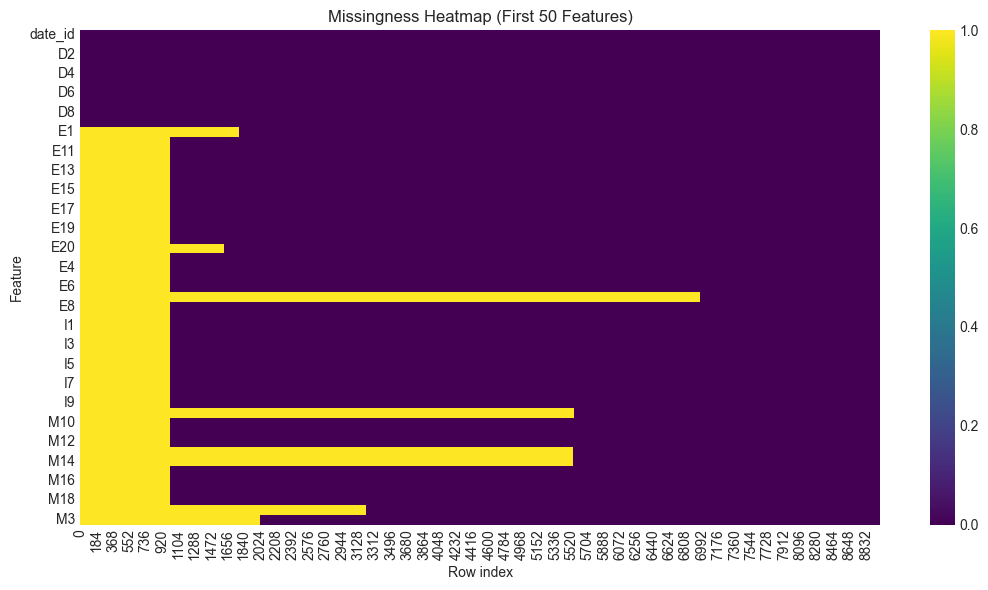

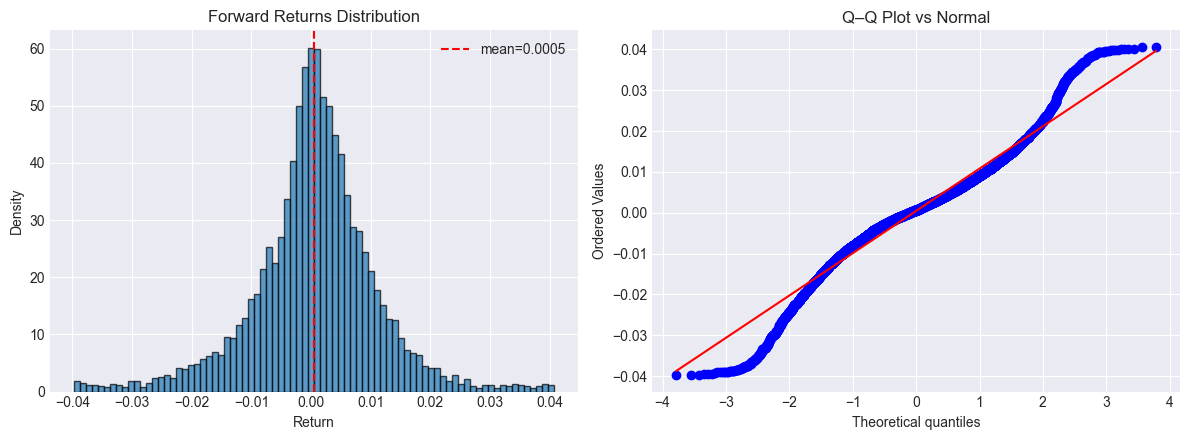

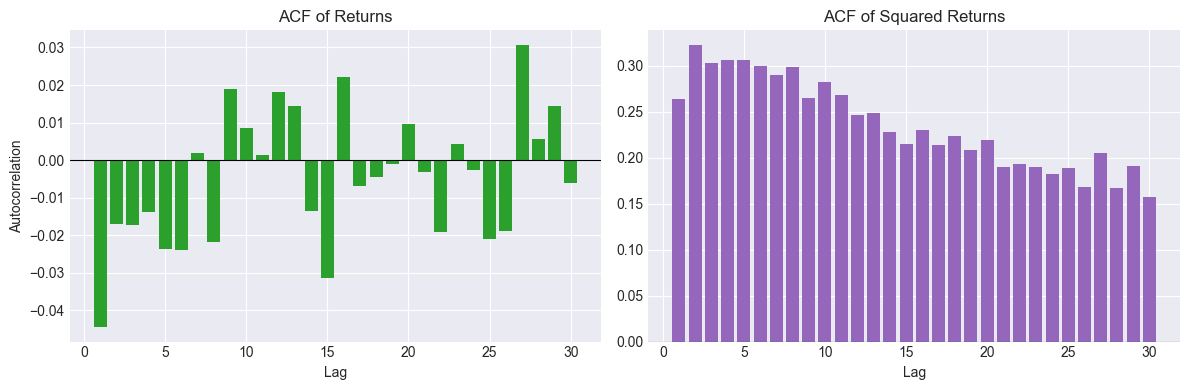

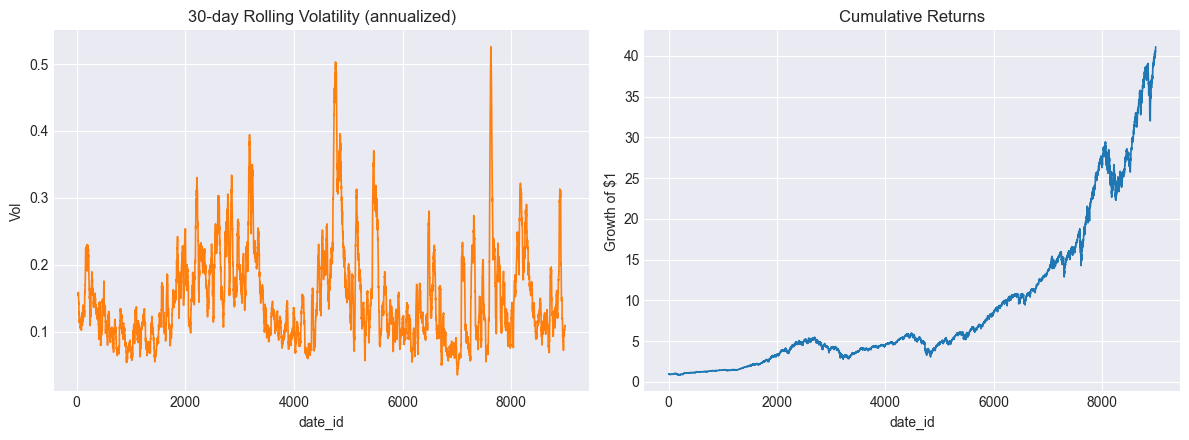

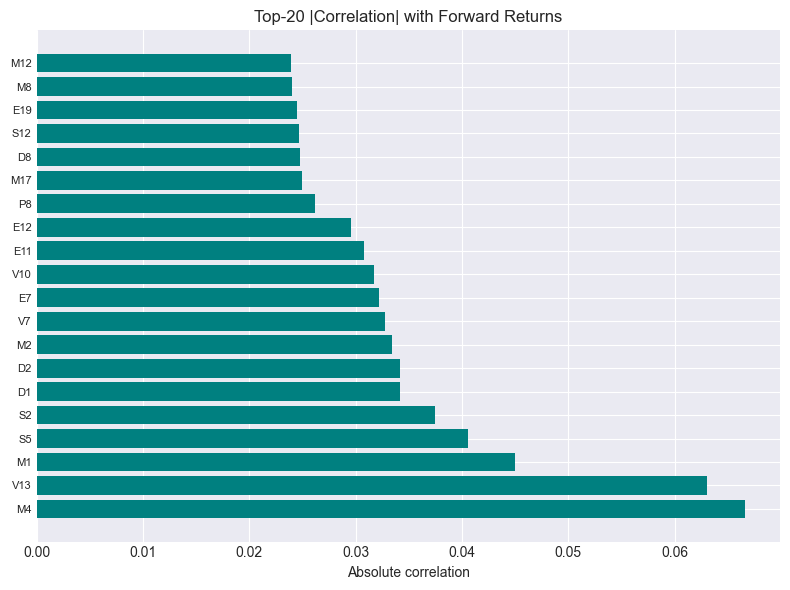

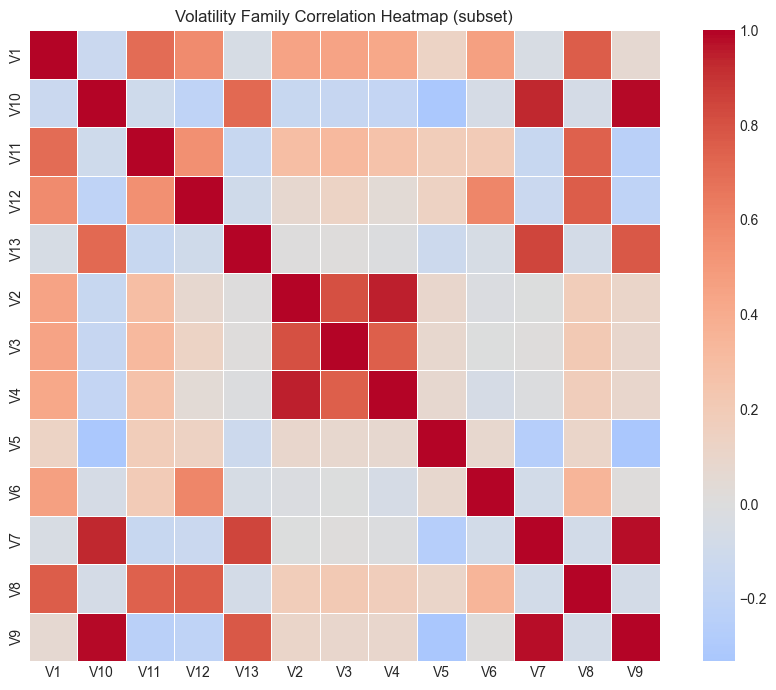

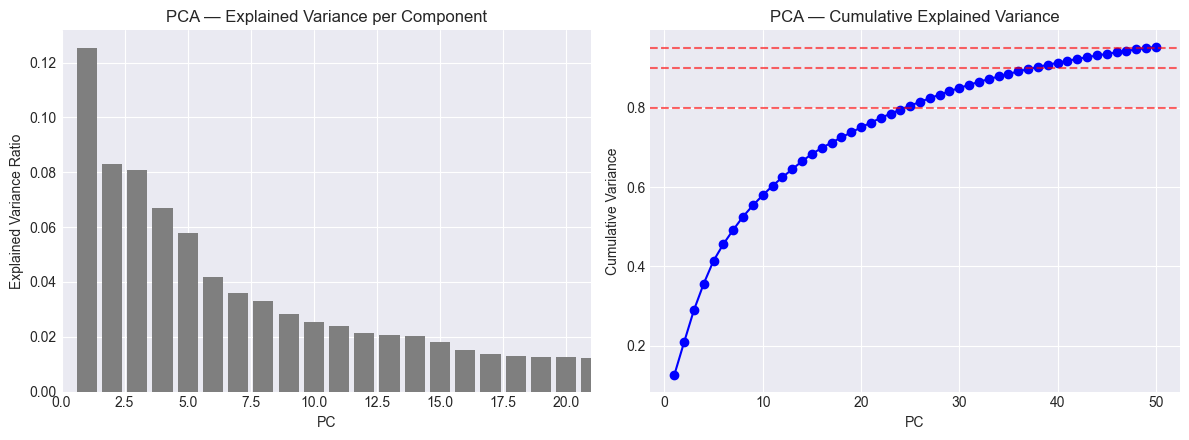

In [4]:
# ===========================================
# Figures for Report — Hull Tactical project
# ===========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
os.makedirs('figs', exist_ok=True)

# -----------------------
# 0) Load training data
# -----------------------
TRAIN_PATH = 'train.csv'  # change if needed
train_df = pd.read_csv(TRAIN_PATH)

# Convenience lists
SPECIAL_COLS = {'date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'is_scored'}
feature_cols = [c for c in train_df.columns if c not in SPECIAL_COLS]
vol_cols     = [c for c in feature_cols if c.startswith('V')]
macro_cols   = [c for c in feature_cols if c.startswith('E')]

# ===============================
# Helper: competition-like metric
# (for val plots if you have allocations)
# ===============================
def adjusted_sharpe_like(df: pd.DataFrame, allocations: np.ndarray) -> float:
    """
    df columns needed: forward_returns, risk_free_rate
    allocations in [0,2]
    """
    r = df['forward_returns'].values
    rf = df['risk_free_rate'].values
    pos = np.clip(np.asarray(allocations), 0.0, 2.0)

    strat_ret = rf * (1 - pos) + pos * r
    strat_excess = strat_ret - rf
    if strat_ret.std() == 0:
        return 0.0

    trading_days = 252
    # geometric mean of excess
    geo_excess = (1 + strat_excess).prod()**(1/len(df)) - 1
    sharpe = geo_excess / strat_ret.std() * np.sqrt(trading_days)

    mkt_vol = r.std() * np.sqrt(trading_days) * 100
    strat_vol = strat_ret.std() * np.sqrt(trading_days) * 100
    excess_vol = max(0, strat_vol / (mkt_vol + 1e-12) - 1.2)
    vol_penalty = 1 + excess_vol

    mkt_excess = r - rf
    mkt_geo = (1 + mkt_excess).prod()**(1/len(df)) - 1
    return_gap = max(0, (mkt_geo - geo_excess) * 100 * trading_days)
    ret_penalty = 1 + (return_gap**2) / 100

    return sharpe / (vol_penalty * ret_penalty)

# ===========================================
# 1) Missingness heatmap (subset of columns)
# ===========================================
fig, ax = plt.subplots(figsize=(11, 6))
subset_cols = ['date_id'] + feature_cols[:50]
miss_mat = train_df[subset_cols].isna()
sns.heatmap(miss_mat.T, cbar=True, ax=ax, cmap='viridis')
ax.set_title('Missingness Heatmap (First 50 Features)')
ax.set_xlabel('Row index')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('figs/fig1_missingness_heatmap.png', dpi=200)
plt.show()

# ===========================================
# 2) Returns distribution + QQ plot (2-panel)
# ===========================================
ret = train_df['forward_returns'].dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Histogram
axes[0].hist(ret, bins=80, density=True, alpha=0.7, color='tab:blue', edgecolor='k')
axes[0].axvline(ret.mean(), color='red', linestyle='--', label=f"mean={ret.mean():.4f}")
axes[0].set_title('Forward Returns Distribution')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Density')
axes[0].legend()

# QQ-plot
stats.probplot(ret, dist="norm", plot=axes[1])
axes[1].set_title('Q–Q Plot vs Normal')

plt.tight_layout()
plt.savefig('figs/fig2_returns_dist_qq.png', dpi=200)
plt.show()

# ===========================================
# 3) ACF of returns and squared returns (2-panel)
# ===========================================
def acf_vals(series, max_lag=30):
    series = pd.Series(series).dropna()
    return [series.autocorr(lag=i) for i in range(1, max_lag+1)]

lags = 30
acf_r  = acf_vals(ret, lags)
acf_r2 = acf_vals(ret**2, lags)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(1, lags+1), acf_r, color='tab:green')
axes[0].axhline(0, color='k', linewidth=0.8)
axes[0].set_title('ACF of Returns')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

axes[1].bar(range(1, lags+1), acf_r2, color='tab:purple')
axes[1].axhline(0, color='k', linewidth=0.8)
axes[1].set_title('ACF of Squared Returns')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.savefig('figs/fig3_acf_returns_sq.png', dpi=200)
plt.show()

# ===========================================
# 4) Rolling 30-day volatility + cumulative returns
# ===========================================
df_sorted = train_df.sort_values('date_id')
ret_s = df_sorted['forward_returns'].fillna(0.0)
idx = df_sorted['date_id']

roll_vol = ret_s.rolling(30).std() * np.sqrt(252)
cum = (1 + ret_s).cumprod()

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].plot(idx, roll_vol, color='tab:orange', linewidth=1.2)
axes[0].set_title('30-day Rolling Volatility (annualized)')
axes[0].set_xlabel('date_id')
axes[0].set_ylabel('Vol')

axes[1].plot(idx, cum, color='tab:blue', linewidth=1.2)
axes[1].set_title('Cumulative Returns')
axes[1].set_xlabel('date_id')
axes[1].set_ylabel('Growth of $1')

plt.tight_layout()
plt.savefig('figs/fig4_rolling_vol_cumret.png', dpi=200)
plt.show()

# ===========================================
# 5) Top-20 absolute correlations with target (exclude leakage)
# ===========================================
safe_feats = [c for c in feature_cols if c != 'market_forward_excess_returns']
corrs = train_df[safe_feats].corrwith(train_df['forward_returns']).abs().sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(len(corrs))[::-1], corrs.values[::-1], color='teal')
ax.set_yticks(range(len(corrs))[::-1])
ax.set_yticklabels(corrs.index[::-1], fontsize=8)
ax.set_xlabel('Absolute correlation')
ax.set_title('Top-20 |Correlation| with Forward Returns')
plt.tight_layout()
plt.savefig('figs/fig5_top_corrs.png', dpi=200)
plt.show()

# ===========================================
# 6) Within-family correlation heatmap (Volatility family V*)
# ===========================================
if len(vol_cols) >= 2:
    vol_df = train_df[vol_cols].copy()
    # Keep manageable subset if too many
    if len(vol_cols) > 20:
        vol_df = vol_df[vol_cols[:20]]
    cm = vol_df.corr()
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(cm, cmap='coolwarm', center=0, ax=ax, square=True, linewidths=0.5)
    ax.set_title('Volatility Family Correlation Heatmap (subset)')
    plt.tight_layout()
    plt.savefig('figs/fig6_volatility_corr_heatmap.png', dpi=200)
    plt.show()

# ===========================================
# 7) (Optional) PCA scree + cumulative variance
# ===========================================
do_pca = True
if do_pca:
    X = train_df[safe_feats].fillna(0.0).values
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)
    n_comp = min(50, Xs.shape[1], Xs.shape[0])
    pca = PCA(n_components=n_comp, random_state=42).fit(Xs)
    evr = pca.explained_variance_ratio_
    cev = np.cumsum(evr)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    axes[0].bar(range(1, len(evr)+1), evr, color='tab:gray')
    axes[0].set_title('PCA — Explained Variance per Component')
    axes[0].set_xlabel('PC')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_xlim(0, min(20, len(evr))+1)

    axes[1].plot(range(1, len(cev)+1), cev, 'bo-')
    for y in [0.8, 0.9, 0.95]:
        axes[1].axhline(y=y, color='r', linestyle='--', alpha=0.6)
    axes[1].set_title('PCA — Cumulative Explained Variance')
    axes[1].set_xlabel('PC')
    axes[1].set_ylabel('Cumulative Variance')
    plt.tight_layout()
    plt.savefig('figs/fig7_pca_variance.png', dpi=200)
    plt.show()

# =========================================================
# 8) (Optional) XGBoost feature importance — if model present
#     Provide a function you can call after training
# =========================================================
def plot_xgb_importance(xgb_model, feature_names, topn=20, fname='figs/fig8_xgb_importance.png'):
    if not hasattr(xgb_model, 'feature_importances_'):
        print('Model has no feature_importances_ attribute.')
        return
    imp = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False).head(topn)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(len(imp))[::-1], imp.values[::-1], color='tab:blue')
    ax.set_yticks(range(len(imp))[::-1])
    ax.set_yticklabels(imp.index[::-1], fontsize=8)
    ax.set_title('XGBoost Feature Importance (gain/weight)')
    ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

# Example usage (uncomment after you have a trained model & feature list):
# plot_xgb_importance(final_model, FEATURES, topn=20)

# =========================================================
# 9) (Optional) Validation equity curve vs market + drawdown
#     Provide a function you can call if you have val df + allocations
# =========================================================
def plot_val_equity_and_drawdown(val_df: pd.DataFrame, allocations: np.ndarray,
                                 fname='figs/fig9_val_equity_drawdown.png'):
    """
    val_df must have columns: date_id, forward_returns, risk_free_rate
    allocations array aligned with val_df rows
    """
    r = val_df['forward_returns'].values
    rf = val_df['risk_free_rate'].values
    pos = np.clip(np.asarray(allocations), 0.0, 2.0)
    strat_ret = rf * (1 - pos) + pos * r

    strat_curve = (1 + strat_ret).cumprod()
    mkt_curve = (1 + r).cumprod()

    # drawdown
    running_max = np.maximum.accumulate(strat_curve)
    dd = strat_curve / running_max - 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    axes[0].plot(val_df['date_id'], mkt_curve, label='Market', lw=1.5)
    axes[0].plot(val_df['date_id'], strat_curve, label='Strategy', lw=1.5)
    axes[0].set_title('Validation: Cumulative Returns')
    axes[0].set_xlabel('date_id'); axes[0].set_ylabel('Growth of $1')
    axes[0].legend()

    axes[1].fill_between(val_df['date_id'], dd*100, 0, color='red', alpha=0.35)
    axes[1].plot(val_df['date_id'], dd*100, color='darkred', lw=1.0)
    axes[1].set_title('Strategy Drawdown (Validation)')
    axes[1].set_xlabel('date_id'); axes[1].set_ylabel('Drawdown (%)')

    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

# =========================================================
# 10) (Optional) k-grid sensitivity for allocation mapping
# =========================================================
def to_allocation(preds: np.ndarray, k: float) -> np.ndarray:
    return np.clip(2.0 * (1.0 / (1.0 + np.exp(-preds * k))), 0.0, 2.0)

def plot_k_sensitivity(val_df: pd.DataFrame, preds: np.ndarray,
                       k_grid=(5, 10, 20, 40, 80, 120),
                       fname='figs/fig10_k_sensitivity.png'):
    scores = []
    for k in k_grid:
        alloc = to_allocation(preds, k)
        s = adjusted_sharpe_like(val_df, alloc)
        scores.append(s)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(k_grid, scores, 'o-', color='tab:purple')
    ax.set_xlabel('k (sigmoid slope)')
    ax.set_ylabel('Adjusted Sharpe (validation-like)')
    ax.set_title('k-Grid Sensitivity on Validation Block')
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    print('k-grid:', k_grid)
    print('scores:', [f'{v:.4f}' for v in scores])

# =========================================================
# 11) (Optional) Calibration: binned preds vs realized mean returns
# =========================================================
def plot_calibration(val_df: pd.DataFrame, preds: np.ndarray, bins=10,
                     fname='figs/fig11_calibration.png'):
    df = val_df[['forward_returns']].copy()
    df['pred'] = preds
    df['bin'] = pd.qcut(df['pred'], q=bins, duplicates='drop')
    grp = df.groupby('bin')['forward_returns'].mean()
    fig, ax = plt.subplots(figsize=(8, 4))
    grp.plot(kind='bar', ax=ax, color='tab:green', edgecolor='k')
    ax.set_title('Calibration: Mean Realized Return by Prediction Decile')
    ax.set_xlabel('Prediction Bin')
    ax.set_ylabel('Mean Forward Return')
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

# =====================
# HOW TO USE OPTIONALS:
# =====================
# After you run your training script and obtain:
#  - final_model (XGBRegressor)
#  - FEATURES (list of column names used by model)
#  - val_df_proc (pandas or polars → convert to pandas) with date_id, forward_returns, risk_free_rate
#  - raw_val_preds (np.ndarray) predictions on val block
#  - val_alloc (np.ndarray) allocations on val block
#
# Example:
#   plot_xgb_importance(final_model, FEATURES)
#
#   val_pd = val_df_proc if isinstance(val_df_proc, pd.DataFrame) else val_df_proc.to_pandas()
#   plot_val_equity_and_drawdown(val_pd[['date_id','forward_returns','risk_free_rate']], val_alloc)
#   plot_k_sensitivity(val_pd[['date_id','forward_returns','risk_free_rate']], raw_val_preds)
#   plot_calibration(val_pd[['forward_returns']], raw_val_preds)


In [3]:
%pip install --upgrade matplotlib seaborn scipy

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.8 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 12.6 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 12.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.1 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------------- ---------------------- 3.1/7.0 MB 15.7 MB/s eta 0:00:01
   ----------------------------------- ---- 6.3/7.0 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 14.7 MB/s  0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   ----- --

In [5]:
# ============================
# Hull Tactical EDA Figures
# ============================
# Generates and saves:
# 1) Returns histogram + normal fit
# 2) ACF of forward_returns (lags 1..30)
# 3) 30-day rolling volatility
# 4) Cumulative returns
# 5) Missingness heatmap (first 50 cols)
# 6) Top-20 |corr| with forward_returns (excl. obvious leakage)
# 7) Example family heatmap (Volatility V*)
# 8) PCA scree (explained variance)
# ============================

import os
import numpy as np
import pandas as pd

# If you're in a headless environment, force a non-interactive backend BEFORE importing pyplot
import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------- config ----------
INPUT_TRAIN = "train.csv"
OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ---------- load ----------
df = pd.read_csv(INPUT_TRAIN)
assert "forward_returns" in df.columns, "train.csv must have 'forward_returns' column."

# small helper: safe col getter
def cols_starting_with(prefix):
    return [c for c in df.columns if c.startswith(prefix)]

# Exclude special columns for feature-only operations
special_cols = {"date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns"}

# ---------- 1) Returns histogram + normal fit ----------
ret = df["forward_returns"].dropna()
mu, sd = ret.mean(), ret.std()

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(ret, bins=80, density=True, alpha=0.6, color="steelblue", edgecolor="black")
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 200)
ax.plot(x, norm.pdf(x, mu, sd), "k--", lw=2, label=f"Normal fit (μ={mu:.4f}, σ={sd:.4f})")
ax.axvline(0, color="red", ls="--", alpha=0.7)
ax.set_title("Forward Returns — Distribution")
ax.set_xlabel("daily returns")
ax.set_ylabel("density")
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "01_returns_hist_normal.png"))
plt.close(fig)

# ---------- 2) ACF (lags 1..30) ----------
lags = range(1, 31)
acf_vals = [ret.autocorr(lag=l) for l in lags]
conf = 1.96 / np.sqrt(len(ret))  # approx CI

fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(lags, acf_vals, color=["#2ca02c" if v>=0 else "#d62728" for v in acf_vals])
ax.axhline(0, color="black", lw=1)
ax.axhline(conf, color="navy", ls="--", alpha=0.5)
ax.axhline(-conf, color="navy", ls="--", alpha=0.5)
ax.set_title("Autocorrelation of Forward Returns (lags 1–30)")
ax.set_xlabel("lag")
ax.set_ylabel("ACF")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "02_returns_acf.png"))
plt.close(fig)

# ---------- 3) 30-day rolling volatility (annualized) ----------
roll_vol = df["forward_returns"].rolling(30, min_periods=15).std() * np.sqrt(252)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(roll_vol.index, roll_vol.values, color="purple", lw=1)
ax.set_title("30-Day Rolling Volatility (Annualized)")
ax.set_xlabel("t")
ax.set_ylabel("vol")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "03_rolling_vol_30d.png"))
plt.close(fig)

# ---------- 4) Cumulative returns ----------
cum = (1.0 + df["forward_returns"].fillna(0)).cumprod()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(cum.index, cum.values, color="darkblue", lw=1.2)
ax.set_title("Cumulative Return (Buy & Hold on Forward Returns)")
ax.set_xlabel("t")
ax.set_ylabel("cumulative")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "04_cumulative_returns.png"))
plt.close(fig)

# ---------- 5) Missingness heatmap (first 50 columns) ----------
miss = df.isna()
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(miss.iloc[:, :min(50, miss.shape[1])], cbar=True, ax=ax, cmap="viridis")
ax.set_title("Missingness Heatmap — First 50 Columns")
ax.set_xlabel("columns")
ax.set_ylabel("rows")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "05_missingness_heatmap_first50.png"))
plt.close(fig)

# ---------- 6) Top-20 |corr| with forward_returns ----------
# Exclude obvious leakage if present
candidate_feats = [c for c in df.columns if c not in special_cols]
corr = df[candidate_feats].corrwith(df["forward_returns"]).abs().dropna().sort_values(ascending=False)
top20 = corr.head(20)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(range(len(top20)), top20.values, color="teal")
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20.index, fontsize=8)
ax.invert_yaxis()
ax.set_title("Top-20 |Correlation| with forward_returns (excl. specials)")
ax.set_xlabel("|corr|")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "06_top20_corr_with_target.png"))
plt.close(fig)

# ---------- 7) Example family heatmap (Volatility V*) ----------
v_cols = cols_starting_with("V")
v_cols = [c for c in v_cols if df[c].notna().any()]
if len(v_cols) >= 2:
    corr_v = df[v_cols].fillna(df[v_cols].median()).corr()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr_v, annot=False, cmap="coolwarm", center=0, ax=ax)
    ax.set_title("Volatility Feature Family — Correlation Heatmap")
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "07_volatility_family_heatmap.png"))
    plt.close(fig)
else:
    print("[info] Not enough V* columns to plot family heatmap.")

# ---------- 8) PCA scree plot ----------
# Build numeric feature matrix (exclude specials and non-numeric)
num_cols_all = [c for c in df.columns if c not in special_cols and pd.api.types.is_numeric_dtype(df[c])]
X = df[num_cols_all].copy()
X = X.fillna(X.median()).fillna(0)

# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Number of components to compute
n_comp = min(50, Xs.shape[1], Xs.shape[0])
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(Xs)
evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].bar(np.arange(1, len(evr)+1), evr, color="#1f77b4")
axes[0].set_title("PCA — Explained Variance by Component")
axes[0].set_xlabel("PC")
axes[0].set_ylabel("ratio")
axes[0].set_xlim(0.5, min(20, len(evr)) + 0.5)

axes[1].plot(np.arange(1, len(cum)+1), cum, "o-", color="#ff7f0e", lw=2)
axes[1].axhline(0.8, color="red", ls="--", alpha=0.6, label="80%")
axes[1].axhline(0.9, color="orange", ls="--", alpha=0.6, label="90%")
axes[1].axhline(0.95, color="green", ls="--", alpha=0.6, label="95%")
axes[1].set_title("PCA — Cumulative Explained Variance")
axes[1].set_xlabel("PC")
axes[1].set_ylabel("cumulative ratio")
axes[1].legend()

fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "08_pca_scree.png"))
plt.close(fig)

print(f"Done. Saved figures to: {OUT_DIR}/")


Done. Saved figures to: figures/
